# Nursing Data Analysis

###### Tae Ken Kim

Say that you are a health official at some US state or an hospital administrator, and you are interested in getting more Registered Nurses for your state/institution. According to the American Association of Colleges of Nursing, "U.S. is projected to experience a shortage of Registered Nurses (RNs) that is expected to intensify as Baby Boomers age and the need for health care grows" (1). Using publicly availiable data, lets develope some insights into the nursing shortage that will help formulate a plan of action to boost the number of nurses.


(1):https://www.aacnnursing.org/news-information/fact-sheets/nursing-shortage

**We will do the analysis and make recommendations in two different scales:**

1. Instituion level - actions that people such as hospital administrators can take
2. State level - actions that can be made at the state government level

<a id='top_summary'></a>

## Summary of Key Findings and Recommendations

### Institution Level

- [Gradient boosting with SMOTE oversampling](#gbm_start) gives the best model, with Matthews correlation coefficient of 0.344. [Logistic regression with SMOTE](#logistic_start) gives MCC=0.268.
- Analyzing these models, [we can recommend](#logistic_conclusions) that to make it more likely that nurses will stay at the institution:
  
    1. Directly hire nurses, and employ them year-round, and offer opportunities for overtime work
    2. Offer orientations and trainings for nurses on team-based and evidence-based care
    3. Money isn't everything: salaries and collective bargaining units are comparible to other indicators
    4. Happiness is the strongest indicator of nurses who stay at their jobs
    5. Value of training programs per nurse are:
        - team-based care training: \\$35484
        - organization emphasis on evidence-based care: \\$32931
        - orientation program for primary nursing position: \\$24544
        - practice management and administration training: \\$19196
        - organization emphasis on care coordination: \\$15181
        
### State Level

- Increase the number of first time nurses, and target nurses with about 4 years of experience for recruitment and retainment efforts. [Details](#state_1)
- Looking at the [plot of average distance moved vs. NPD](#state_2), states above the line of best fit should investigate why they are not getting many nurses from nearby states, and find ways to recruit more from them.
- We can use bayesian statistics to calculate [disaffinity](#disaffinity_intro): a measure of how unlikeable a state is to nurses compared to the general population
- Offering a limited-time increase in salary to new nurses is more cost effective than lowering the tuiton. [Details](#cost)

#### National Sample Survey of Registered Nurses (NSSRN)

The main dataset we will be using is the NSSRN, published by Bureau of Health Workforce, a US government entity under Health Resources & Services Administration.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.ndimage.filters import uniform_filter1d
import pyreadstat
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import bs4
from bs4 import BeautifulSoup
from tensorflow import keras
from tensorflow.keras import layers
import spacy
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import cartopy.crs as ccrs
from tqdm import tqdm
import seaborn as sns
import dill
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,matthews_corrcoef, make_scorer
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours as ENN

from nordvpn_switcher import initialize_VPN, rotate_VPN, terminate_VPN

import ntpath
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
import math
import copy
import os
import random
import pickle
import json
import webbrowser
from time import sleep

from tax_bracket import tax_bracket
from distance import midpoint
from distance import distance
from us_map import make_map
from state_name import census_and_regions


In [2]:
[state_census, region] = census_and_regions()
df_2018, meta_2018 = pyreadstat.read_sas7bdat('NSSRN2018_SAS_encoded_package\\NSSRN_2018_PUF.sas7bdat')
weight = df_2018['RKRNWGTA']

In [3]:
#helper function to handle region to state, and vice versa
def r2s(dict_in):
    dict_out = copy.deepcopy(dict_in)
    for key in dict_in.keys():
        if key in region:
            for st in region[key]:
                dict_out[st] = dict_in[key]
            dict_out.pop(key)
    return dict_out
            
def s2r(dict_in):
    dict_out = copy.deepcopy(dict_in)
    for key in region:        
        dict_out[key] = np.mean([dict_in[st] for st in region[key]])
        for st in region[key]:
            dict_out.pop(st)
    return dict_out

def region_explain():
    print(' ')
    print('(D1: VT, RI     D4: ND,SD      D8: MT, WY     D9: HI, AK)')
    
#function that takes region, and gives back state names
def r2slist(st):
    if st in region:
        return region[st]
    else:
        return [st]
    
def slist2r(st):
    for key in region:
        if st in region[key]:
            return key

In [4]:
titles=['Graduated State', 'First Licensed State', 'Current State']
varnames=['ED_NDLOC_ST_PUF','ED_FRN_ST_PUF','PN_LOC_ST_PUF']
for key in region.keys():
    for st in region[key]:
        for vn in varnames:
            df_2018.loc[df_2018[vn]==st,vn]=key

The dataframe "df_2018" will contain all of the survey data. We are interested in three measures: the graduated, first licensed, and currently practicing states of registered nurses.

Some of the survey results give aggregate regions rather than state level data (D1, D4, D8, D9), but it is not consistent in its reporting style. As such, it makes sense to combine each region's data into one group for all states in the region.

States in D1(RI, VT), D4(ND, SD), and D8(MT, WY) are geographically close, so combining these states isn't too far-fetched. D9(AK, HI) states are only reported at the regional level for all three metrics so we have no other choice.

Now, AK and HI are obviously very different states, so any insights drawn from D9 might be useless. However, since we will be looking at the rates at which nurses enter and leave each state, and since they are both outside the contiguous United States, they will pose similar hurdles for people looking to transiton in/out of these states. Therefore, the insights drawn from D9 data might still prove useful.

## Institutional Level - Analysis of Nurses Who Changed Jobs

**We can build models to predict which nurses will change jobs, and using them, also identify facotrs that makes it more likely for nurses to change jobs**.

Section B of the survey asks for working conditions for the job respondents held in Dec 31, 2017, and then asks if they have left the position since then. First, we only filter for respondents who held a patient-care job in Dec 31, 2017, and had been working at that job for less than 5 years. **We also filter out people who left the job due to outside reasons**(disability, retirement), as they do not relate to job conditions. Then, some of the columns, like ones that code for geography, is not very relevant, so we drop those. I made every attempt to ordinally encode categorical variables, sometimes combining answers if necessary. We also define a helper function called 'explain'. Passing a variable name to it will print out description of it.

We will utilize several different modeling techniques: **logistic regression, gradient boosting machine, neural network, and support vector machine**. Also, our dataset is **severely imbalanced**: after cleaning the dataset, only 12% of our data is from people who left jobs. We can employ oversampling techniques(**random oversampling, SMOTE, ADASYN**) to try to overcome this.

In [6]:
#universal data cleaning
survey_key = pd.read_excel('survey_key.xls').replace(np.nan, '')
df_learn = copy.deepcopy(df_2018).loc[(df_2018['PN_EMPLYD']==1)&(df_2018['PN_NEWEMP']==1)&
                                      (df_2018['PN_PATCARE']==1)&(df_2018['PN_EHR']!=3),:]


leave_reasons=survey_key['2018 NSSRN VARIABLE NAME'][survey_key['2018 NSSRN QUESTIONNAIRE ITEM NUMBER']=='C1'].to_numpy()
outside_reasons=['LE_LVE_DISAB', 'LE_LVE_FAM', 'LE_LVE_LAID', 'LE_LVE_COMMTE','LE_LVE_RETIRE','LE_LVE_SPEMP']
#outside_reasons=['LE_LVE_DISAB', 'LE_LVE_LAID']
inside_reasons=[]
for reason in leave_reasons:
    if reason not in outside_reasons:
        inside_reasons.append(reason)

any_outside = np.zeros(df_learn.shape[0])
for reason in outside_reasons:
    any_outside = np.logical_or(any_outside, (df_learn[reason] == 1).to_numpy())


df_learn =df_learn.loc[~any_outside,:]



"""droplist"""
#populate dropcols we are gonna use    
dropcols =[] 
#keep = ['B','C','D','E','F','H']
keep= ['B']
remove = ['B2']

#make drop list of unnecessary stuff
for i,row in survey_key.iterrows():
    
    if row['2018 NSSRN QUESTIONNAIRE ITEM NUMBER']=='':
        dropcols.append(row['2018 NSSRN VARIABLE NAME'])
        
    elif ((row['2018 NSSRN QUESTIONNAIRE ITEM NUMBER'] == 'IMP_FLAG') or
          (row['2018 NSSRN QUESTIONNAIRE ITEM NUMBER'] == 'DERIVED') or
          not(row['2018 NSSRN QUESTIONNAIRE ITEM NUMBER'][0] in keep) or
          (row['Action1']=='del') or
          (row['2018 NSSRN QUESTIONNAIRE ITEM NUMBER'] in remove)):
        dropcols.append(row['2018 NSSRN VARIABLE NAME'].strip())

#drop stuff in dropcols
df_learn.drop(dropcols, axis=1, inplace=True)


"""bool list"""
#find boolean variables
boolcols=[]

for i,row in survey_key.iterrows():
    if row['VALUES'].strip()=='1 ="YES"\n2 ="NO"':
        boolcols.append(row['2018 NSSRN VARIABLE NAME'].strip())

#revalue false from 2 to 0
for col in boolcols:
    if col in df_learn.columns:        
        df_learn.loc[df_learn[col]==2,col]=0
        
        
#helper function to explain variable names
def explain(name):

    underscore = -name[::-1].find('_')
    
    if name[underscore:].isnumeric():
        code = name[:underscore-1]
        num =int(name[underscore:])
    else:
        code = name
        num = 0
    
    try:
        info = survey_key.loc[survey_key['2018 NSSRN VARIABLE NAME']==code,['2018 NSSRN QUESTIONNAIRE ITEM NUMBER','DESCRIPTION']].to_numpy()[0]
        print('{}: {}'.format(info[0],info[1]))
        
        if num !=0:
            text = survey_key['VALUES'][survey_key['2018 NSSRN VARIABLE NAME']==code].to_numpy()[0]
            ind=[m.start() for m in re.finditer('\n', text)]
            ind.insert(0,-1)
            ind.append(len(text))
            print('    '+text[ind[num-1]+1:ind[num]])
    except:
        print('Does not exist')

 
 
Random guessing with knowledge of y would achieve 78.7% accuracy


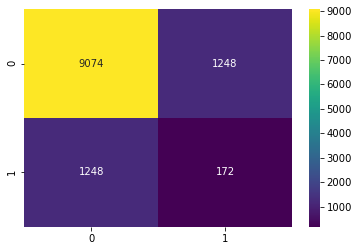

 
 
Unskilled estimator would achieve achieve 87.9% accuracy
 
 
Even with the perfect model, we expect 21.1% false positives


In [15]:
y = df_learn['PN_LFTWRK']
print(' ')
print(' ')
y_tot=y.shape[0]
y_leave = sum(y)
y_stay = y_tot-y_leave
h0_conf =np.array( [[np.float(y_stay**2/y_tot), np.float(y_stay*y_leave/y_tot)],
         [np.float(y_stay*y_leave/y_tot), np.float(y_leave**2/y_tot)]])

tp = h0_conf[0,0]
tn = h0_conf[1,1]
fp = h0_conf[1,0]
fn = h0_conf[0,1]
print('Random guessing with knowledge of y would achieve {:.1f}% accuracy'.format(100*(h0_conf[0,0]+h0_conf[1,1])/y_tot))         

sns.heatmap(h0_conf,annot=True,cmap='viridis',fmt=".0f")
plt.show()

print(' ')
print(' ')
print('Unskilled estimator would achieve achieve {:.1f}% accuracy'.format(100*(y_stay/y_tot)))  


# assuming perfect model
s =1-sum(y)/y.shape[0]
l=sum(y)/y.shape[0]
n=[s**i for i in range(6)]
print(' ')
print(' ')
print('Even with the perfect model, we expect {:.1f}% false positives'.format(100*np.sum([n[i]-n[5] for i in range(1,6)])/np.sum(n[0:-1])))


### Model Metrics and Baselines

We will use **Matthews correlation coefficient** as our scoring metric, since it performs better for imbalanced dataset. For instance, in our dataset, random guessing with $P(leaving) = 0.12$ achieve 78.7% accuracy, and guessing that all nurse will stay achieves 87.9% accuracy. In those cases, MCC results in zero, making it a more suitable metric.

Interesting thing to note is that **even the perfect model will have more false positives than true positives.** Let's assume that:

1. Probability of leaving is constant at 12% through the first 5 years
2. Same number of new nurses each year

Then. we expect that 21.1% of all nurses surveyed will eventually leave(i.e. has all the indicators that causes a nurse to leave), but had not done so in the previous year.

<a id='logistic_start'></a>
### Logistic Regression Classifier

We are first going to do logistic regression on the data. Cateogrical variables that could not be ordinally encoded were encoded using dummy encoding. **The reference group was chosen as the category with mean closest to the grand mean**, which makes it the worst category for prediction.

We will use logistic regression with L2 penalty. We are using L2 rather than L1 because we aren't too keen on simplifying the model parameters, as they aren't too numerous, and we do not want to miss any factors that may affect the nurses' decision to change jobs. We will sweep a range of hyperparameters for the penalty, and also apply the oversampling methods.



[back to top](#top_summary)

In [16]:
#%% logistic

#pick the variables
y = df_learn['PN_LFTWRK']
x = df_learn.drop('PN_LFTWRK',axis=1)

#remapping

x.loc[x['PN_NEWEMP']==1,'PN_NEWEMP'] = 3/12
x.loc[x['PN_NEWEMP']==2,'PN_NEWEMP'] = 9/12
x.loc[x['PN_NEWEMP']==3,'PN_NEWEMP'] = 1
x.loc[x['PN_NEWEMP']==4,'PN_NEWEMP'] = 0

x.loc[(x["PN_ORIENT"]==1) &(x["PN_PRECEP"] == 0),"PN_ORIENT"] = 0.5

x.loc[x['PN_EHR'] == 2,'PN_EHR'] = 0
x.loc[x['PN_EHR'] == 3,'PN_EHR'] = 0.5

for name in ['PN_WE_TBC','PN_WE_IPT','PN_WE_HIT','PN_OE_CARE','PN_OE_DISPL','PN_OE_TBC','PN_OE_EBC']:
    x.loc[x[name]==2,name] = 2/3
    x.loc[x[name]==3,name] = 1/3
    x.loc[x[name]==4,name] = 0
    x.loc[x[name]==5,name] = 0

for name in ['PN_THTYP_PTP','PN_THTYP_RN','PN_THTYP_NP','PN_THTYP_OTH_PUF','PN_THTYP_PVDTP']:
    x.loc[x[name].isna(),name]=0

x.loc[x['PN_SATISFD']==2,'PN_SATISFD'] = 2/3
x.loc[x['PN_SATISFD']==3,'PN_SATISFD'] = 1/3
x.loc[x['PN_SATISFD']==4,'PN_SATISFD'] = 0
    
x['PN_WRK'] += -1
x['PN_MTHPY'] = x['PN_MTHPY']/12
x[['PN_HRS_SCHED_PUF','PN_HRS_WRK_PUF']] = x[['PN_HRS_SCHED_PUF','PN_HRS_WRK_PUF']]/40
x[['PN_TS_PCC','PN_TS_CARE','PN_TS_SUPER','PN_TS_RESRCH','PN_TS_TEACH','PN_TS_NNT','PN_TS_OTH']] = x[['PN_TS_PCC','PN_TS_CARE','PN_TS_SUPER','PN_TS_RESRCH','PN_TS_TEACH','PN_TS_NNT','PN_TS_OTH']]/100
x[['PN_POP_PNAT','PN_POP_NEWB','PN_POP_PED','PN_POP_ADOL','PN_POP_ADLT','PN_POP_GER']] = x[['PN_POP_PNAT','PN_POP_NEWB','PN_POP_PED','PN_POP_ADOL','PN_POP_ADLT','PN_POP_GER']]/100

#scale salary
sig = np.std(x['PN_EARN_PUF'])
m = np.mean(x['PN_EARN_PUF'])
x['PN_EARN_PUF'] = (x['PN_EARN_PUF']-m)/sig

#categories

cats = (['PN_EMPSIT',3,4], #name, base anwer, answer limit
        ['PN_EMPSET',1,4],
        ['PN_LVL_PUF',2,20],
        ['PN_CS_PUF', 17,25]
        )
GM = y.mean()

for entry in cats:  
    name = entry[0]
    means = []
    for ii in x[name].value_counts().index:
        means.append(y[x[name]==ii].mean())
    
    base = np.argsort(abs(means-GM))[0]
    
    for ii in x[name].value_counts().index:
        i = int(ii)
        if i != base:
            x[name+'_'+str(i)] = x[name]==i
    
    x.drop(name,axis=1,inplace=True)
 
            
#addtional drops
dropcols2 = ['PN_PRECEP','PN_TELHLTH','PN_THPERS','PN_TS_PCC','PN_POP_PNAT']
x.drop(dropcols2, axis=1,inplace=True)

logit_varnames = copy.deepcopy(x.columns)

We can check for correlated variables. Apparently in our dataset, nurses who work in dermatology also work in emergency rooms. They each have a good number of samples (1964 and 1854, respectively), they don't have obvious relations, and they are just one pair of variables, so we will just continue as-is. We can also determine the base level of prediction by calculating what the confusion matrix would be if we randomly guessed using just the data in y.

In [17]:
cor = x.corr()

print('Correlations:')
print('--------------')

for i in range(cor.shape[0]):
    for j in range(cor.shape[0]):
        if (i>j)&(abs(cor.iloc[i,j])>0.9):
            print('{} and {}  ({})'.format(cor.index[i],cor.index[j],abs(cor.iloc[i,j])))
            explain(cor.index[i])
            print(' ')
            explain(cor.index[j])
            print(' ')
      



Correlations:
--------------
PN_CS_PUF_6 and PN_LVL_PUF_7  (0.9091620013769862)
B17_C: CLINICAL SPECIALITY
    6 = DERMATOLOGY
 
B16: LEVEL OF CARE
    7 = EMERGENCY
 


In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=4059)
mcs=make_scorer(matthews_corrcoef)

Cs_list = {'0':np.linspace(0.1,0.4,num=50),
           'R':np.linspace(0.05,0.15,num=50),
           'S':np.linspace(0.001,0.3,num=50),
           'A':np.linspace(0.001,0.5,num=20)}

titles={'0':'No Oversampling','R':'Random Oversampling','S':'SMOTE','A':'ADASYN'}
oversampler={'R':RandomOverSampler,'S':SMOTE,'A':ADASYN}

mc_list={}
acc_list={}
bacc_list={}
C_list={}

def logistic_predict(mode):
 
    # Cs = Cs_list[mode]
    Cs = np.linspace(0.001,1,num=50)
    mc=[]
    acc=[]
    bacc=[]
    for C in tqdm(Cs):
        
        m=[]
        a=[]
        b=[]       
        for (train, test) in cv.split(x, y):
            x_train, y_train = x.iloc[train], y.iloc[train]
            x_test, y_test = x.iloc[test], y.iloc[test]
            if mode in oversampler:
                x_os, y_os = oversampler[mode](random_state=4387).fit_resample(x_train, y_train)
            else:
                 x_os, y_os =  x_train, y_train
           
            logit_model = linear_model.LogisticRegression(C=C, penalty='l2',max_iter=1000,random_state=1614).fit(x_os,y_os)
            m.append(matthews_corrcoef(y_test,logit_model.predict(x_test)))
            a.append(metrics.accuracy_score(y_test,logit_model.predict(x_test)))
            b.append(metrics.balanced_accuracy_score(y_test,logit_model.predict(x_test)))
            
        mc.append(np.mean(m))
        acc.append(np.mean(a))
        bacc.append(np.mean(b))
    
    mc_list[mode]=np.array(mc)
    acc_list[mode]=np.array(acc)
    bacc_list[mode]=np.array(bacc)  
    C_list[mode] = Cs[np.argsort(mc)[-1]]


def logistic_plot_sweep(mode):

    mc = mc_list[mode]
    acc =  acc_list[mode]
    bacc = bacc_list[mode]
    # Cs = Cs_list[mode]
    Cs = np.linspace(0.001,1,num=50)
    C = C_list[mode]
    
    fig,axes = plt.subplots(2,2,figsize=(5,5))
    axes[0,0].plot(Cs,mc)
    axes[0,0].set_title('Matthews')
    
    axes[0,1].plot(Cs,acc)
    axes[0,1].set_title('Accuracy')
    
    axes[1,0].plot(Cs,bacc)
    axes[1,0].set_title('Balanced Accuracy')    
    
    
    
    h_conf=[]

    for (train, test) in cv.split(x, y):
        x_train, y_train = x.iloc[train].values.astype(float), y.iloc[train].values.astype(float)
        x_test, y_test = x.iloc[test].values.astype(float), y.iloc[test].values.astype(float)
        
        if mode in oversampler:
            x_os, y_os = oversampler[mode](random_state=4387).fit_resample(x_train, y_train)
        else:
            x_os, y_os =  x_train, y_train
             
        logit_model = linear_model.LogisticRegression(C=C, penalty='l2',max_iter=1000,random_state=6541).fit(x_os, y_os)
        h_conf.append(confusion_matrix(y_test, logit_model.predict(x_test)))
        
    h_conf_mean = np.zeros(shape=(2,2))
    for i in range(2):
        for ii in range(2):
            h_conf_mean[i,ii] = np.mean([h[i,ii] for h in h_conf])
    axes[1,1]=sns.heatmap(h_conf_mean,annot=True,cmap='viridis',fmt=".0f")
    plt.suptitle('{} (C = {:.3f}, MCC = {:.3f})'.format(titles[mode],C,max(mc)))
    plt.tight_layout() 
    plt.show()
    print(' ')
    print(' ')

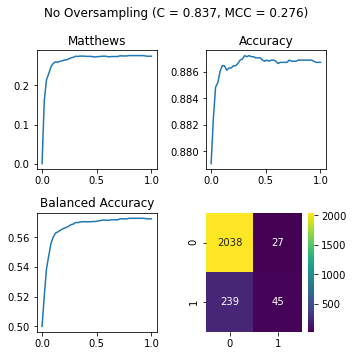

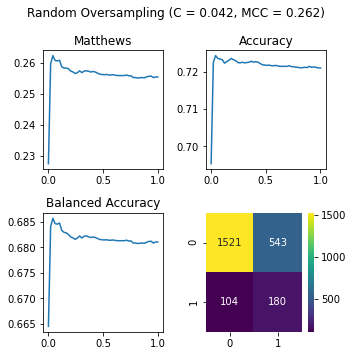

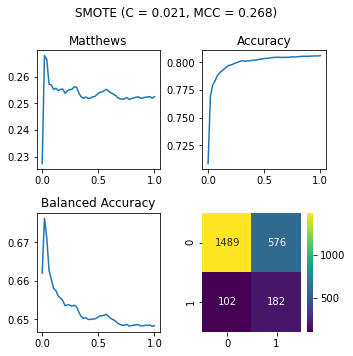

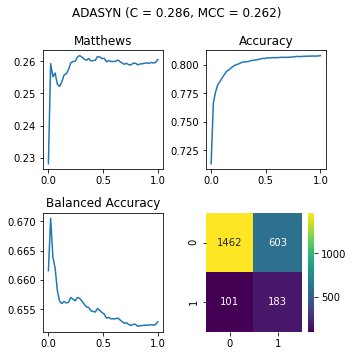

 
 
No Oversampling
C = 0.837, MCC = 0.276
 
Random Oversampling
C = 0.042, MCC = 0.262
 
SMOTE
C = 0.021, MCC = 0.268
 
ADASYN
C = 0.286, MCC = 0.262
 


In [33]:
with open("logit_results.dill", "rb") as f:
    [mc_list,acc_list,bacc_list,C_list] = dill.load(f)
   
for mode in [*titles.keys()][:]:
    #logistic_predict(mode)
    logistic_plot_sweep(mode)


    
for mode in [*titles.keys()][:]:    
    print(titles[mode])
    print('C = {:.3f}, MCC = {:.3f}'.format(C_list[mode],max(mc_list[mode])))
    print(' ')

The two models seem to be quite different in that not oversampling has low recall and high precision, whereas the oversampling methods have high recall and low precision.

If our purpose is to prevent nurses from leaving, **we would prefer to have high recall** because:

1. We already determined that even a perfect model will have low precision
2. Since we are interested in identifying factors that make nurses leave, having false positives are much better than missing many indicators of nurses leaving.

Thus, we can take the SMOTE model, and look at the top 20 most significant parameters that predict both nurses staying(negative) and leaving(positive).

In [35]:
max_entries=20

C = 0.021
logit_model = linear_model.LogisticRegression(C=C, penalty='l2',max_iter=1000,random_state=6541).fit(x,y)

print('Factors for nurses staying/leaving:')
print('----------------------------')
for i,c_i in enumerate(reversed(np.argsort(abs(logit_model.coef_[0])))):
    name = x.columns[c_i]
    print("{} ({:.3f})".format(name,logit_model.coef_[0][c_i]))
    explain(name)
    print(' ')
    if i==max_entries:
        break


Factors for nurses staying/leaving:
----------------------------
PN_SATISFD (-1.774)
B24: SATISFACTION IN PRIMARY NURSING POSITION
 
PN_EMPSIT_1 (0.853)
B10: PRIMARY NURSING POSITION EMPLOYMENT SITUATION ON 12/31/17 
    1 = "EMPLOYED THROUGH AN EMPLOYMENT AGENCY AS A TRAVELING NURSE"
 
PN_EMPSIT_3 (-0.646)
B10: PRIMARY NURSING POSITION EMPLOYMENT SITUATION ON 12/31/17 
    3 = "EMPLOYED BY THE ORGANIZATION OR FACILITY AT WHICH YOU WERE WORKING"
 
PN_PRACTICE (-0.383)
B25: ABLE TO PRACTICE TO EXTENT OF KNOWLEDGE/EDUCATION/TRAINING
 
PN_HRS_WRK_PUF (0.322)
B14: HOURS WORKED IN A TYPICAL WEEK
 
PN_MTHPY (-0.278)
B12: MONTHS PER YEAR WORKED
 
PN_TT_TBC (0.245)
B20: TRAINING TOPICS - TEAM-BASED CARE
 
PN_EARN_PUF (-0.240)
B26: ANNUAL EARNINGS FROM PRIMARY NURSING POSITION
 
PN_EMPSIT_4 (-0.239)
B10: PRIMARY NURSING POSITION EMPLOYMENT SITUATION ON 12/31/17 
    4 = "SELF-EMPLOYED OR WORKING AS NEEDED"
 
PN_OE_EBC (-0.227)
B19: ORGANIZATION EMPHASIS ON EVIDENCE-BASED CARE
 
PN_ORIENT (-0.16

<a id='logistic_conclusions'></a>

Lets build some insights into actions that health institutions may take.

**1. Directly hire nurses, and employ them year-round, offer opportunities for overtime work**

- Leave factors: employed through an employment agency as a traveling nurse (0.853), hours worked in a typical week (0.322), hours scheduled in a typical week (0.125)
- Stay factors: employed by the organization or facility at which you were working (-0.646), months per year worked (-0.278)
    
**2. Offer orientations and trainings for nurses on team-based and evidence-based care**
    
- Leave factors: wanting team-based care training (0.245), wanting practice management and administration training (0.133)
- Stay factors: organization emphasis on evidence-based care(-0.227), orientation program for primary nursing position (-0.169), wanting social determinants of health training(-0.140), organization emphasis on care coordination (-0.105)

**3. Money isn't everything: salaries (-0.240) collective bargaining units (-0.113) are comparible to other indicators**

**4. Happiness is the strongest indicator of nurses who stay at their jobs**

- satisfaction in primary nursing position (-1.774), able to practice to extent of knowledge/education/training (-0.383)
    
**5. Work settings matter**
    
- Leave factors: step-down/transitional/progressive/telemetry (0.099)
- Stay factors: clinic/ambulatory (-0.168),school nurse (-0.139), other types of settings (-0.106)


However, lets look more closely at salary and hours worked per week. Hours worked in a typical week has positive coefficient(0.322) so, it should indicate that overtime work makes nurses more likely to leave. However, in our data, standard deviation of salary is equal to \\$34756, while hours worked per week was normalized by 40 hrs/week. Thus, we can predict that effect of one hour/week of overtime would be offset by: $ \$34756*0.322/(40*0.240)= \$1166 $, which is approximately $22 per week. This is much less than the hourly overtime pay that most nurses would make, which means the **model predicts that offering overtime would actually make nurses more likely to stay**. Best explanation for this paradox would be that jobs requiring more overtime are the types of jobs that people dislike, but all else being equal, nurses prefer to work overtime. In a similar way, we can put dollar amounts on other parameters, speficially on trainings and orientations:

- wanting team-based care training: \\$35484
- organization emphasis on evidence-based care: \\$32931
- orientation program for primary nursing position: \\$24544
- wanting practice management and administration training: \\$19196
- organization emphasis on care coordination: \\$15181
    
These dollar amounts are the **value that these programs offer per nurse**. I can be guidelines for deciding between spending resources on these training programs versus increasing compensation. For example, if a team-based care training costs $600k/yr over its lifecycle to create and maintain, and there are 20 nurses at the institution, it would be more cost effective to offer the training rather than increasing compensation of the nurses.



[back to top](#top_summary)

<a id='gbm_start'></a>
### Data Cleaning and Encoding - Gradient Boost using XGBoost

Rather than try the classification with random forest, using gradient boosting methods in the XGBoost library would be a better alternative. We have to re-encode the categorical dataset, this time with one-hot encoding rather than dummy variable. We are also going to use **randomized search cross validation** to tune the hyperparameters. Then, with those hyperparameters, we can compare the importance calculated from the ensembles with the coefficients calculated. For each set of hyperparameters, we also sweep threshold values.

[back to top](#top_summary)

In [37]:
#pick the variables
y = df_learn['PN_LFTWRK']
x = df_learn.drop('PN_LFTWRK',axis=1)

#remapping

x.loc[x['PN_NEWEMP']==1,'PN_NEWEMP'] = 3/12
x.loc[x['PN_NEWEMP']==2,'PN_NEWEMP'] = 9/12
x.loc[x['PN_NEWEMP']==3,'PN_NEWEMP'] = 1
x.loc[x['PN_NEWEMP']==4,'PN_NEWEMP'] = 0

x.loc[(x["PN_ORIENT"]==1) &(x["PN_PRECEP"] == 0),"PN_ORIENT"] = 0.5

x.loc[x['PN_EHR'] == 2,'PN_EHR'] = 0
x.loc[x['PN_EHR'] == 3,'PN_EHR'] = 0.5

for name in ['PN_WE_TBC','PN_WE_IPT','PN_WE_HIT','PN_OE_CARE','PN_OE_DISPL','PN_OE_TBC','PN_OE_EBC']:
    x.loc[x[name]==2,name] = 2/3
    x.loc[x[name]==3,name] = 1/3
    x.loc[x[name]==4,name] = 0
    x.loc[x[name]==5,name] = 0

for name in ['PN_THTYP_PTP','PN_THTYP_RN','PN_THTYP_NP','PN_THTYP_OTH_PUF','PN_THTYP_PVDTP']:
    x.loc[x[name].isna(),name]=0

x.loc[x['PN_SATISFD']==2,'PN_SATISFD'] = 2/3
x.loc[x['PN_SATISFD']==3,'PN_SATISFD'] = 1/3
x.loc[x['PN_SATISFD']==4,'PN_SATISFD'] = 0
    
x['PN_WRK'] += -1
x['PN_MTHPY'] = x['PN_MTHPY']/12
x[['PN_HRS_SCHED_PUF','PN_HRS_WRK_PUF']] = x[['PN_HRS_SCHED_PUF','PN_HRS_WRK_PUF']]/40
x[['PN_TS_PCC','PN_TS_CARE','PN_TS_SUPER','PN_TS_RESRCH','PN_TS_TEACH','PN_TS_NNT','PN_TS_OTH']] = x[['PN_TS_PCC','PN_TS_CARE','PN_TS_SUPER','PN_TS_RESRCH','PN_TS_TEACH','PN_TS_NNT','PN_TS_OTH']]/100
x[['PN_POP_PNAT','PN_POP_NEWB','PN_POP_PED','PN_POP_ADOL','PN_POP_ADLT','PN_POP_GER']] = x[['PN_POP_PNAT','PN_POP_NEWB','PN_POP_PED','PN_POP_ADOL','PN_POP_ADLT','PN_POP_GER']]/100

#scale salary
# sig = np.std(x['PN_EARN_PUF'])
# m = np.mean(x['PN_EARN_PUF'])
# x['PN_EARN_PUF'] = (x['PN_EARN_PUF']-m)/sig

#categories

cats = (['PN_EMPSIT',3,4], #name, base anwer, answer limit
        ['PN_EMPSET',1,4],
        ['PN_LVL_PUF',2,20],
        ['PN_CS_PUF', 17,25]
        )


for entry in cats:  
    name = entry[0]
    
    for i in range(1,entry[2]+1):
        x[name+'_'+str(i)] = x[name]==i
    
    x.drop(name,axis=1,inplace=True)
 
            
#addtional drops
dropcols2 = ['PN_PRECEP','PN_TELHLTH','PN_THPERS']
x.drop(dropcols2, axis=1,inplace=True)



""" model"""

mcs=make_scorer(matthews_corrcoef)
cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=4059)
params = {
    'max_depth':[2,3,4,5],
    'learning_rate':[0.01,0.05,0.1,0.2],
    'min_child_weight':[1,2,3,4,5],
    'gamma':[0,0.1,0.2,0.3,0.4,0.5],
    'colsample_bytree':[0.25,0.5,0.75,1]}

mcx_list={}
par_hist_list={}
b_par_list={}
threshold_list={}

titles={'0':'No Oversampling','R':'Random Oversampling','S':'SMOTE','A':'ADASYN'}
oversampler={'R':RandomOverSampler,'S':SMOTE,'A':ADASYN,'SNC':SMOTENC,'SNN':SMOTEENN}

def GBM_predict(mode):
    if mode not in titles:
        raise('Use correct mode')
    mcx=[]
    par_hist=[]
    for i in tqdm(range(30)):
        b_par ={}
        while True:
            for key in params:
                b_par[key] = np.random.choice(params[key])
            if b_par not in par_hist:
                par_hist.append(b_par)
                break   
        m=[]
        for (train, test) in cv.split(x, y):
            x_train, y_train = x.iloc[train].values.astype(float), y.iloc[train].values.astype(float)
            x_test, y_test = x.iloc[test].values.astype(float), y.iloc[test].values.astype(float)
            if mode=='SNC':
                categoricals = [*range(len(x.columns))]
                continuous = [*x.columns].index('PN_EARN_PUF')
                categoricals.remove(continuous)
                x_os, y_os = SMOTENC(categoricals,random_state=2353).fit_resample(x_train, y_train)  
            else:
                x_os, y_os = oversampler[mode](random_state=2353).fit_resample(x_train, y_train)  
            dtrain = xgb.DMatrix(x_os,label=y_os)
            dtest = xgb.DMatrix(x_test,label=y_test)
           
            GBM=xgb.train(b_par,dtrain)
            m.append((y_test,GBM.predict(dtest)))
        mcx.append(m)       
    mcx = np.array(mcx)
    
    mcx_list[mode] = mcx
    par_hist_list[mode] = par_hist
    

def GBM_best_par(mode):
    
    mcx=mcx_list[mode]
    par_hist=par_hist_list[mode]
    #figure out which was best
    m_list=np.zeros(shape=(50,mcx.shape[0]))
    thresholds=np.linspace(0.1,0.6,num=50)
    for i in range(mcx.shape[0]):  
        for ti,threshold in enumerate(thresholds):
            m_test= [any(mcx[i,ii,1]>threshold) and any(mcx[i,ii,1]<=threshold) for ii in range(5)]
            if all(m_test):     
                m_list[ti,i]=np.mean([matthews_corrcoef(mcx[i,ii,0],(mcx[i,ii,1]>threshold).astype(float))
                                      for ii in range(5)])  
    
    threshold_list[mode] = thresholds[np.where(m_list==np.amax(m_list))[0][0]]
    max_i=np.where(m_list==np.amax(m_list))[1][0]
    
    print('Best MCC = {:.3f}'.format(np.amax(m_list)))
    text=''
    b_par = par_hist[max_i]
    for key in params:
        text+='{}: {}    '.format(key,b_par[key])
    print(text)
    b_par_list[mode] = b_par

def GBM_CV(mode,b_par = None,threshold=None):
    # run the model through cv
    if threshold is None:
        threshold=threshold_list[mode]
    h_conf=[]
    mcc_list = []
    if b_par is None:
        b_par = b_par_list[mode]
    
    for (train, test) in cv.split(x, y):
        x_train, y_train = x.iloc[train].values.astype(float), y.iloc[train].values.astype(float)
        x_test, y_test = x.iloc[test].values.astype(float), y.iloc[test].values.astype(float)
        if mode=='SNC':
            categoricals = [*range(len(x.columns))]
            continuous = [*x.columns].index('PN_EARN_PUF')
            categoricals.remove(continuous)
            x_os, y_os = SMOTENC(categoricals,random_state=2353).fit_resample(x_train, y_train)  
        else:
            x_os, y_os = oversampler[mode](random_state=2353).fit_resample(x_train, y_train)  
        dtrain = xgb.DMatrix(x_os,label=y_os)
        dtest = xgb.DMatrix(x_test,label=y_test)
        GBM=xgb.train(b_par,dtrain)    
        y_pred = GBM.predict(dtest)>threshold
        h_conf.append(confusion_matrix(y_test, y_pred))
        mcc_list.append(matthews_corrcoef(y_test,y_pred))
        
    h_conf_mean = np.zeros(shape=(2,2))
    for i in range(2):
        for ii in range(2):
            h_conf_mean[i,ii] = np.mean([h[i,ii] for h in h_conf])
    sns.heatmap(h_conf_mean,annot=True,cmap='viridis',fmt=".0f")
    plt.suptitle('{} (MCC = {:.3f})'.format(titles[mode],np.mean(mcc_list)))
    plt.tight_layout()
    plt.show()  

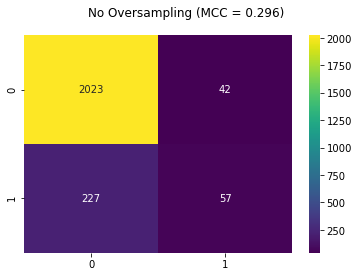

In [40]:
#no os
GBM = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
random_search=RandomizedSearchCV(GBM,param_distributions=params,n_iter=30,scoring=mcs,
                                 cv=5,random_state=2021,verbose=0)
random_search.fit(x,y)

print('Best MCC = {:.3f}'.format(random_search.best_score_))
text=''
b_par = random_search.best_params_
for key in params:
    text+='{}: {}    '.format(key,b_par[key])
print(text)

h_conf=[]
mcc_list = []
best_estimator = copy.deepcopy(random_search.best_estimator_)
for (train, test) in cv.split(x, y):
    x_train, y_train = x.iloc[train].values.astype(float), y.iloc[train].values.astype(float)
    x_test, y_test = x.iloc[test].values.astype(float), y.iloc[test].values.astype(float)
    best_estimator.fit(x_train,y_train)
    y_pred = best_estimator.predict(x_test)
    h_conf.append(confusion_matrix(y_test, y_pred))
    mcc_list.append(matthews_corrcoef(y_test,y_pred))
    
h_conf_mean = np.zeros(shape=(2,2))
for i in range(2):
    for ii in range(2):
        h_conf_mean[i,ii] = np.mean([h[i,ii] for h in h_conf])
sns.heatmap(h_conf_mean,annot=True,cmap='viridis',fmt=".0f")
plt.suptitle('No Oversampling (MCC = {:.3f})'.format(np.mean(mcc_list)))
plt.show()         



Best MCC = 0.347
max_depth: 3    learning_rate: 0.1    min_child_weight: 2    gamma: 0.5    colsample_bytree: 0.75    


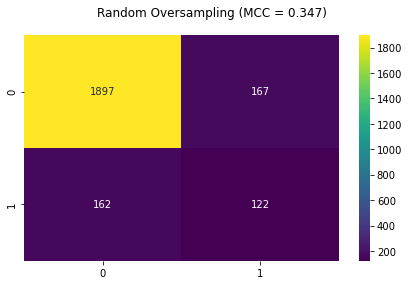

Best MCC = 0.344
max_depth: 2    learning_rate: 0.1    min_child_weight: 2    gamma: 0.0    colsample_bytree: 1.0    


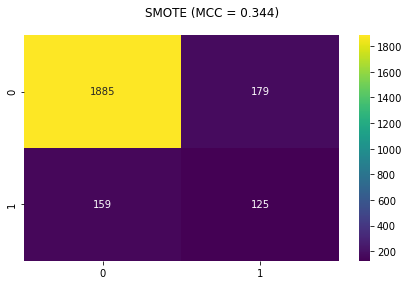

Best MCC = 0.340
max_depth: 2    learning_rate: 0.2    min_child_weight: 1    gamma: 0.3    colsample_bytree: 0.75    


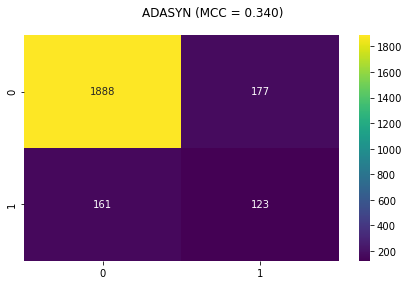

In [41]:
#with open("GBM_results.dill", "rb") as f:
#    [mcx_list,par_hist_list,b_par_list,threshold_list] = dill.load(f)

#os
for mode in list(titles.keys())[1:]:
    GBM_predict(mode)
    GBM_best_par(mode)
    GBM_CV(mode)


Here, the OS methods yield definitively better MCC than the base dataset. Let's choose SMOTE as the best classifier, as it gives the best recall.

PN_SATISFD (286.9)
B24: SATISFACTION IN PRIMARY NURSING POSITION

PN_EMPSIT_1 (193.2)
B10: PRIMARY NURSING POSITION EMPLOYMENT SITUATION ON 12/31/17 
    1 = "EMPLOYED THROUGH AN EMPLOYMENT AGENCY AS A TRAVELING NURSE"

PN_PRACTICE (178.8)
B25: ABLE TO PRACTICE TO EXTENT OF KNOWLEDGE/EDUCATION/TRAINING

PN_EMPSIT_3 (121.3)
B10: PRIMARY NURSING POSITION EMPLOYMENT SITUATION ON 12/31/17 
    3 = "EMPLOYED BY THE ORGANIZATION OR FACILITY AT WHICH YOU WERE WORKING"

PN_EARN_PUF (59.8)
B26: ANNUAL EARNINGS FROM PRIMARY NURSING POSITION

PN_MTHPY (49.0)
B12: MONTHS PER YEAR WORKED

PN_TT_TBC (22.1)
B20: TRAINING TOPICS - TEAM-BASED CARE

PN_LVL_PUF_9 (8.9)
B16: LEVEL OF CARE
    9 = HOME HEALTH/HOSPICE



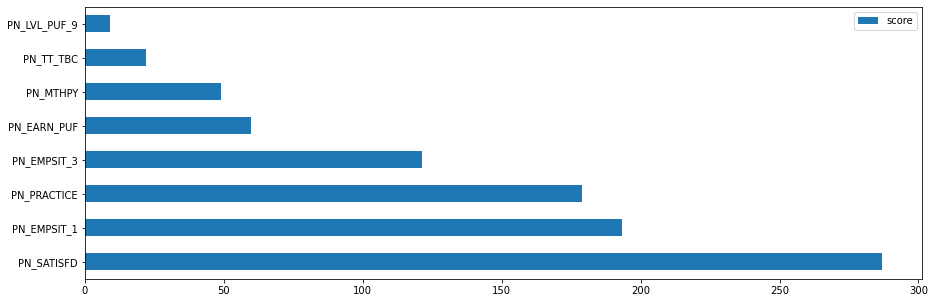

In [43]:
mcx = mcx_list['S']

#figure out which was best
m_list=np.zeros(shape=(50,mcx.shape[0]))
thresholds=np.linspace(0.1,0.6,num=50)
for i in range(mcx.shape[0]):  
    for ti,threshold in enumerate(thresholds):
        m_test= [any(mcx[i,ii,1]>threshold) and any(mcx[i,ii,1]<=threshold) for ii in range(5)]
        if all(m_test):     
            m_list[ti,i]=np.mean([matthews_corrcoef(mcx[i,ii,0],(mcx[i,ii,1]>threshold).astype(float))
                                  for ii in range(5)])
  
threshold = thresholds[np.where(m_list==np.amax(m_list))[0][0]]
max_i=np.where(m_list==np.amax(m_list))[1][0]
b_par = par_hist_list['R'][max_i]

# run the full dataset
x_os, y_os = RandomOverSampler(random_state=2353).fit_resample(x,y)  
dtrain = xgb.DMatrix(x_os,label=y_os)
GBM=xgb.train(b_par,dtrain)    
    

#feature importance
feature_importance = GBM.get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())
df_feat_xgb = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
df_feat_xgb.plot(kind='barh', figsize=(15,5))

for index in df_feat_xgb.index[0:8]:
    print('{} ({:.1f})'.format(index,df_feat_xgb.loc[index,"score"]))
    explain(index)
    print('')

This seems to be in agreement with the logistic model. We can also do neural network and SVC, along with SMOTE+ENN resampling on the dataset, but they do not result in better models or give additional insights. These model codes can be found in the additional_predictions file.




## State Level Analysis

There are two ways of increasing the number of nurses in a state.

1. Attract nurses from other states
2. Keep the nurses working in your state

We are limited in our data to graduation states, first licensed state, and current state; we can't track exact movement of nurses when they move to different states. However, we can plot the percentage of nurses who stayed in their first licensed state as a function of years worked. I am assuming that first licensed state is the state where each nurse had their first job, and ignoring nurses who retired, as the survey does not provide data on retired nurses(nurses not maintaining an active license).

Text(0, 0.5, 'Rate of change')

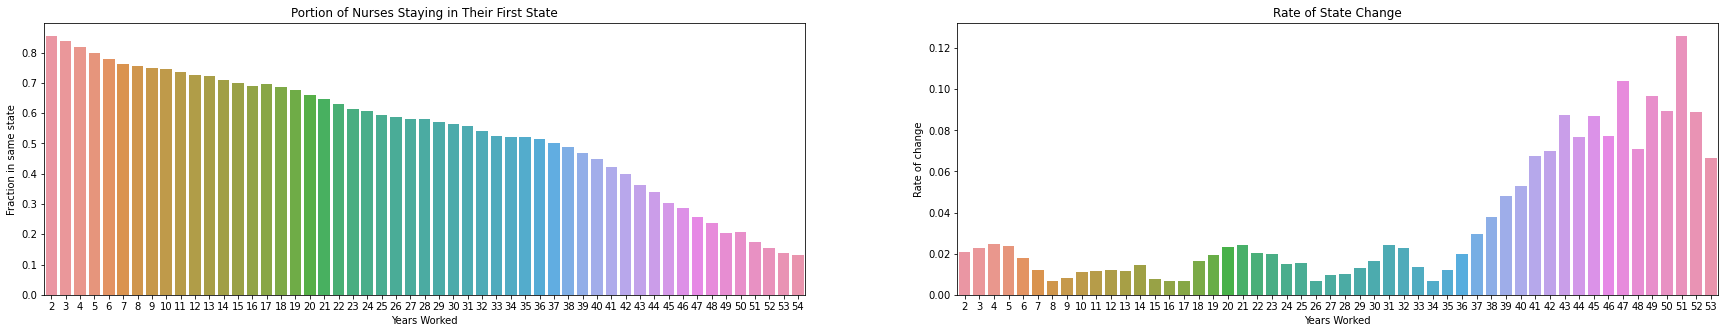

In [5]:
#check if first state and current state is the same. If one is a D region, use both. If one entry is .L, get rid of it
#1 = same, 0 = not same, -1 = omit
ss = np.zeros(df_2018.shape[0],dtype=int)
for i in range(len(ss)):
    
    cs= df_2018.PN_LOC_ST_PUF[i]  #current state
    fs =df_2018.ED_FRN_ST_PUF[i]
    
    #if(fs =='.L') or (cs=='.L'):    #check if they are still working
    if fs =='.L':
        ss[i] = -1
    elif fs == cs:
        ss[i] = 1
    elif (fs in region):
        if cs in region[fs]:
            ss[i] = 1
    elif(cs in region):
        if fs in region[cs]:
            ss[i] = 1
           
yrw = (2018-df_2018.ED_FRN_YR_PUF.astype('int')).to_numpy()
yb = pd.DataFrame({'years_worked':yrw,'same_state':ss,'weight':weight}).loc[lambda df:df['same_state']!=-1,:]

""""make histogram to explore data"""
hist_bins = np.zeros(yb.years_worked.unique().max())

for i in range(len(hist_bins)):
    tot = yb['weight'][yb['years_worked']==i].sum()
    ss = yb['weight'][(yb['years_worked']==i)&(yb['same_state']==1)].sum()
    if tot != 0:
        hist_bins[i] = ss/tot

from scipy.ndimage.filters import uniform_filter1d
y = uniform_filter1d(hist_bins[2:], size=5)
barplot_x = [str(int) for int in range(len(hist_bins))]
fig, ax = plt.subplots(1,2,figsize=(30,5))
sns.barplot(x=barplot_x[2:],y=y,ax=ax[0])
ax[0].set_title('Portion of Nurses Staying in Their First State')
ax[0].set_xlabel('Years Worked')
ax[0].set_ylabel('Fraction in same state')

ydiff = np.zeros(len(y)-1)
for i in range(len(ydiff)):
    ydiff[i] = (y[i]-y[i+1])/y[i]
yy = uniform_filter1d(ydiff, size=3)
sns.barplot(x=barplot_x[2:-1],y=yy,ax=ax[1])
ax[1].set_title('Rate of State Change')
ax[1].set_xlabel('Years Worked')
ax[1].set_ylabel('Rate of change')

<a id='state_1'></a>
We can see that once a nurse starts their career in a state, there is only around 2% chance each year that they will move to a different state for at least three decades. Therefore, the most effective way to increase the number of nurses is to **increase the number of first time nurses**. If we aim to recruit nurses with experience, we should **target nurses with about 4 years of experience**, as they are more likely to move states, and they have many years before retirement. By the same logic, **retainment efforts could be targeted towards the same group** to yield maximum benefit. For example, a state might offer a boost to the nursing salary(through tax credit, direct payments, etc) for nurses with 5 or less years of experience.

[back to top](#top_summary)

What factors might affect the first state of practice that nurse choose? One factor may be the state in which they graduated.


Percentage of graduates staying after graduation
------------------------------------------------
LA: 99%      NM: 99%      TX: 98%      GA: 97%      
CA: 97%      OH: 97%      WA: 96%      FL: 95%      
MI: 95%      SC: 95%      OK: 95%      NC: 95%      
MA: 95%      IL: 95%      KS: 94%      D9: 93%      
PA: 91%      OR: 91%      D1: 90%      TN: 89%      
NJ: 89%      UT: 88%      IN: 88%      ME: 88%      
KY: 88%      MO: 88%      ID: 87%      MD: 87%      
MN: 87%      WI: 87%      NE: 86%      VA: 84%      
CO: 83%      IA: 82%      AL: 80%      NV: 80%      
CT: 79%      NY: 79%      AR: 76%      AZ: 75%      
D8: 75%      MS: 74%      NH: 71%      WV: 71%      
D4: 70%      DE: 67%      DC: 32%      
 
(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)


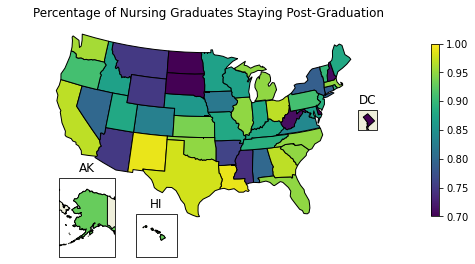

In [5]:
st_list =df_2018['ED_NDLOC_ST_PUF'].unique()
df_gfc = pd.DataFrame(data={'grad': [df_2018.loc[lambda df:(df['ED_NDLOC_ST_PUF'] == st)&(df['ED_FRN_YR_PUF']>=2013), 'RKRNWGTA'].sum() for st in st_list],
                        'first': [df_2018.loc[lambda df:(df['ED_FRN_ST_PUF'] == st)&(df['ED_FRN_YR_PUF']>=2013), 'RKRNWGTA'].sum() for st in st_list],
                        'current': [df_2018.loc[lambda df:(df['PN_LOC_ST_PUF'] == st)&(df['ED_FRN_YR_PUF']>=2013), 'RKRNWGTA'].sum() for st in st_list]},
                      index=st_list)
df_gfc.drop(index='.L',inplace=True)

graduated_state_axis = df_gfc['grad'].sort_values(ascending=False).index
first_state_axis = df_gfc['first'].sort_values(ascending=False).index
current_state_axis = df_gfc['current'].sort_values(ascending=False).index

"""heatmap - graduate vs first state"""
hm_gf_raw = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int) #y,x

for gsi,gs in enumerate(graduated_state_axis):
    for fsi,fs in enumerate(graduated_state_axis):  #enumerate over gsa so x and y axis will have the same order
        try:
            hm_gf_raw[gsi][fsi] = df_2018.loc[lambda df:(df['ED_NDLOC_ST_PUF'] == gs)&(df['ED_FRN_ST_PUF'] == fs)&(df['ED_FRN_YR_PUF']>=2013), 'RKRNWGTA'].sum()
        except:
            pass
            
#normalize by the total graduate number
hm_gf = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int)
for gsi,gs in enumerate(graduated_state_axis): 
    total = sum(hm_gf_raw[gsi,:])
    if total>0:
        hm_gf[gsi,:]=hm_gf_raw[gsi,:]/total*100;   
       
    
#report results in order

gf_stay_i = np.flip(np.argsort([hm_gf[i,i] for i in range(df_gfc.shape[0])]))

print("Percentage of graduates staying after graduation")
print("------------------------------------------------")

report = ''
for i in range(df_gfc.shape[0]):
    report+='{}: {}%      '.format(graduated_state_axis[gf_stay_i[i]],hm_gf[gf_stay_i[i],gf_stay_i[i]])
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)

region_explain()
   

#draw heatmap   
map_data = {}
cmap = plt.cm.get_cmap('viridis')
data_range = [0.7, 1]
map_title = 'Percentage of Nursing Graduates Staying Post-Graduation'
for i in range(df_gfc.shape[0]):
    stname = graduated_state_axis[i]
    if stname in region.keys():
        for st in region[stname]:            
            map_data[st]=cmap((hm_gf[i,i]-70)/30)
    else:
        map_data[stname]=cmap((hm_gf[i,i]-70)/30)   


from us_map import make_map
make_map(map_data,cmap,data_range,map_title)

As expected, all states(except DC) got majority of their own graduates to stay for their first jobs. So first recommendation for any state is to
**increase the number of nursing students in the state.**

Weighting by the total graduates of each state(as we did above) gives us a origin centric metric: it measures the percentage of graduates from each state(origin) that will go to a particular state(destination). If we normalize by first licensed state, it will give a destination centric metric: for each state's nursing population, it will tell us where they graduated from.

If we are interested in boosting the first-time nursing population of a state by attracting more nurses from other regions, we do not care about the destination of this state's graduates, but rather the origins of the state's nursing population. i.e. If many first time nurses in NJ went to nursing school in PA, NJ may decide to redouble their recruiting efforts in PA. Here is a heatmap of this destination centric metric.

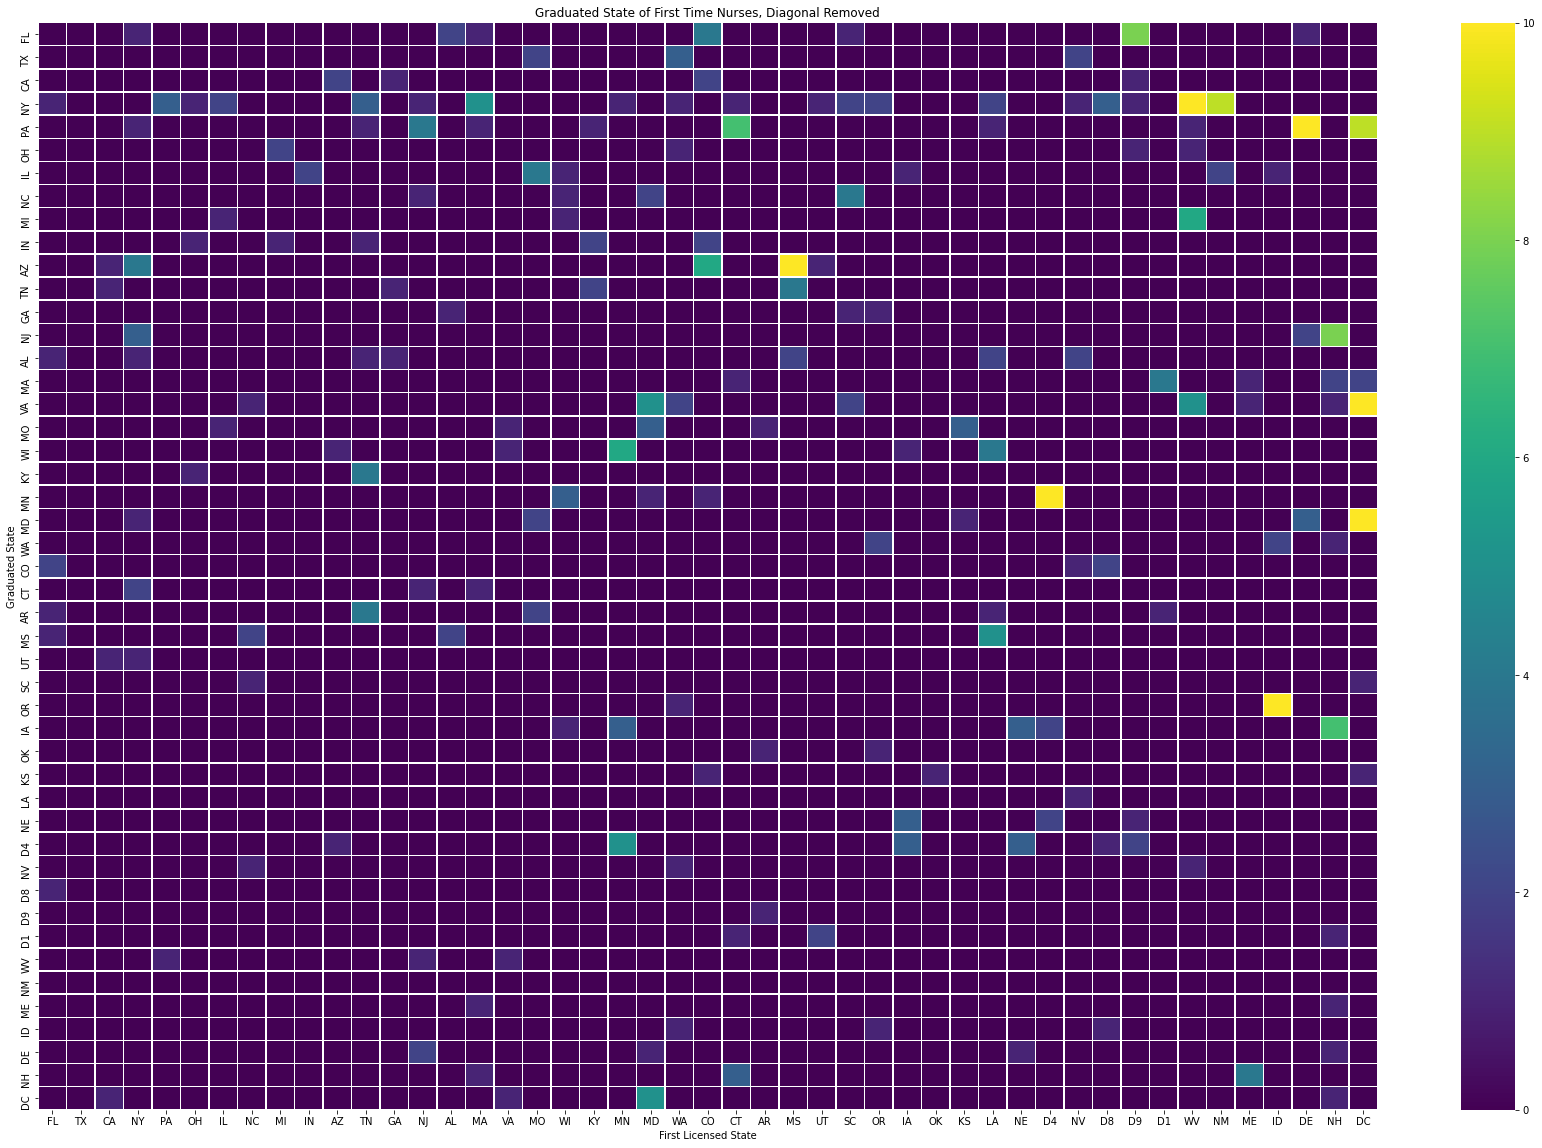

 
(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)


In [6]:
hm_fg = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int)
for gsi,gs in enumerate(graduated_state_axis): 
    total = sum(hm_gf_raw[:,gsi])
    if total>0:
        hm_fg[:,gsi]=hm_gf_raw[:,gsi]/total*100;

hm_fg_diag = copy.deepcopy(hm_fg)

for i in range(df_gfc.shape[0]):
    hm_fg_diag[i,i]=0
        
fig2, ax2 = plt.subplots(figsize=(30,20))
ax2 = sns.heatmap(hm_fg_diag, linewidth=0.5,cmap="viridis",xticklabels=graduated_state_axis,yticklabels=graduated_state_axis,vmin=0,vmax=10)
plt.title('Graduated State of First Time Nurses, Diagonal Removed')
plt.xlabel("First Licensed State")
plt.ylabel("Graduated State")
plt.show()  

region_explain()

Looking at few standouts, it certainly seems that geographic distance plays a big role in nursing graduates deciding to cross state borders. i.e. DC gets lots of nurses from MD and VA, OR from WA, MN from the Dakotas. We can measure the degree to which geographic distance plays a role in nurses' decisions to move states, by finding the average distance of out-of-state graduate nurses for each state. For a given state, higher average distance moved will generally signify how attaractive that state is to nurses, as it is able to attract people from far away.

Average Distance Moved by Out-of-State Graduates (mi)
------------------------------------------------
D9: 2247 mi     NV:  970 mi     AR:  960 mi     NM:  946 mi     
WA:  923 mi     OR:  873 mi     UT:  819 mi     CA:  794 mi     
FL:  714 mi     AZ:  640 mi     D8:  617 mi     MS:  581 mi     
NY:  567 mi     CO:  538 mi     GA:  483 mi     NC:  420 mi     
LA:  392 mi     NH:  368 mi     KS:  279 mi     MO:  276 mi     
D1:  275 mi     NE:  275 mi     VA:  270 mi     ID:  262 mi     
IL:  252 mi     TX:  246 mi     D4:  245 mi     WV:  243 mi     
TN:  237 mi     IA:  236 mi     MN:  204 mi     OH:  192 mi     
WI:  191 mi     MD:  190 mi     SC:  187 mi     MA:  177 mi     
AL:  174 mi     OK:  146 mi     ME:  142 mi     KY:  140 mi     
CT:  124 mi     PA:  123 mi     MI:  123 mi     NJ:  113 mi     
DE:   98 mi     IN:   85 mi     DC:   66 mi     
 
(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)


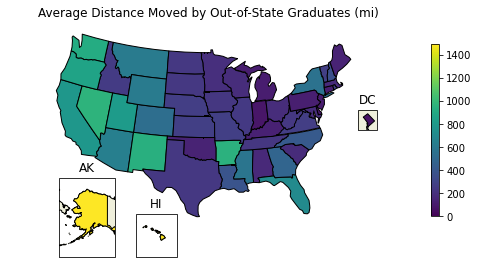

In [7]:
from distance import distance
from distance import midpoint

#function to get locations of states and regions (weighted by population for regions)
def locate(st):
    if st in region.keys():
        loc1 = state_census.loc[region[st][0],['LATITUDE','LONGITUDE']].to_numpy()
        loc2 = state_census.loc[region[st][1],['LATITUDE','LONGITUDE']].to_numpy()
        pop1 = state_census.loc[region[st][0],['POPULATION']]
        pop2 = state_census.loc[region[st][1],['POPULATION']]
        return midpoint(loc1,loc2,pop1,pop2)
    else:
        return state_census.loc[st,['LATITUDE','LONGITUDE']].to_numpy()



avg_dist = {}

for fsi,fs in enumerate(graduated_state_axis):  #we iterate fs over gs because the hm_gf array was with gs indices

    n_total = sum(hm_gf_raw[:,fsi])-hm_gf_raw[fsi,fsi]
    dist_total = 0    
    fsloc = locate(fs)
    
    for gsi, gs in enumerate(graduated_state_axis):
        if gs != fs:
            gsloc = locate(gs)
            dist_total += distance(fsloc,gsloc)*hm_gf_raw[gsi,fsi]
 
    avg_dist[fs] = dist_total/n_total*0.621371

# report text
dist_i = np.flip(np.argsort(list(avg_dist.values())))

print("Average Distance Moved by Out-of-State Graduates (mi)")
print("------------------------------------------------")

report = ''
for i in range(df_gfc.shape[0]):
    report+='{}: {:4.0f} mi     '.format(graduated_state_axis[dist_i[i]],avg_dist[graduated_state_axis[dist_i[i]]])
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)
region_explain()

#draw map
map_data = {} #colors
cmap = plt.cm.get_cmap('viridis')
data_range = [0, 1500]
map_title = 'Average Distance Moved by Out-of-State Graduates (mi)'
for i in range(df_gfc.shape[0]):
    stname = graduated_state_axis[i]
    if stname in region.keys():
        for st in region[stname]:            
            map_data[st]=cmap(avg_dist[stname]/1500)
    else:
        map_data[stname]=cmap(avg_dist[stname]/1500)   
        
from us_map import make_map
make_map(map_data,cmap,data_range,map_title)

<a id='state_2'></a>

D9 have by far the largest distance moved, but this does not accurately reflect its attractiveness to nurses, as they are not in the US mainland.

The northeast seem to have shorter average distance moved. However,the northeast also happens to have higher population density. Densely populated areas will tend to have shorter average distance, while sparsely populated areas will tend to have larger average distance (as evidenced by the west coast and D9). We can correct for this by calculating a *nearby population density*.

I define for a state n, the nearby population density *NPD* to be:

   \begin{equation} NPD = \sum_{m \neq n} \frac{population_m}{distance_{nm}^2} \end{equation}

Since there is an inverse relationship between NPD and average distance moved, we can linearize by plot 1/NPD vs. average distance:

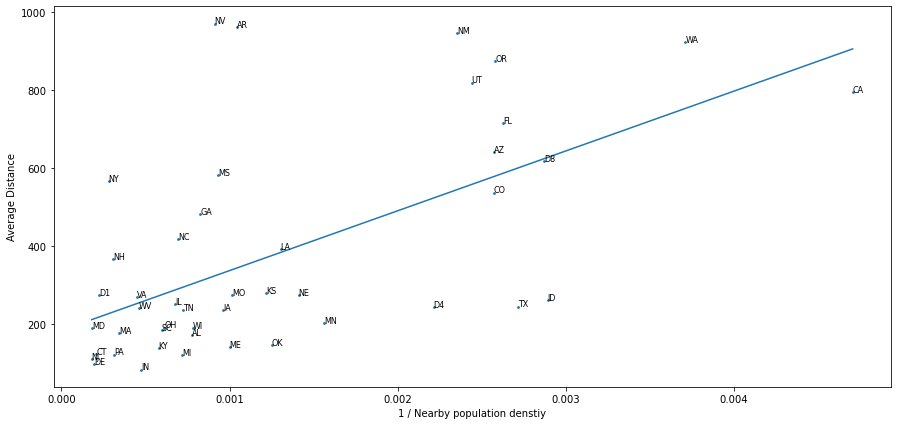

In [8]:
from scipy.optimize import curve_fit
#weight by distance^2 and plot scatter
nearby_population_density = {}

for st in state_census.index:
    density = 0
    for st_nearby in state_census.index:
        if st_nearby != st:
            dist = distance(locate(st),locate(st_nearby))
            density+= state_census['POPULATION'][st_nearby]/(dist**2)
    nearby_population_density[st] = density
    
fig, ax = plt.subplots(figsize=(15,7))
xlist=[1/s2r(nearby_population_density)[st] for st in graduated_state_axis if (st!='DC')&(st!='D9')]
ylist=[avg_dist[st] for st in graduated_state_axis if (st!='DC')&(st!='D9')]
ax.scatter(xlist,ylist,s=3)
ax.set_xlabel('1 / Nearby population denstiy')
ax.set_ylabel('Average Distance')
for i, txt in enumerate([st for st in graduated_state_axis if (st!='DC')&(st!='D9')]):
    ax.annotate(txt, (xlist[i], ylist[i]),fontsize=8)
    
z= stats.linregress(xlist,y=ylist)
xp = np.linspace(min(xlist),max(xlist),100)
yp = z.slope*xp+z.intercept
ax.plot(xp,yp)   

**States above the line of best fit, such as NV, gets their out-of-state nurses from far away states rather than from nearby states.** So to boost the nurses in NV with OOS nurses, NV **should investigate why they are not getting many nurses from nearby states, and find ways to recruit more from them** (Like CA, which has huge population but not many nurses crossing into NV).

[back to top](#top_summary)

<a id='disaffinity_intro'></a>
## Disaffinity: A Bayesian Analysis

We have so far mostly looked at how to attact more nurses from other states. The next question is "How can we retain more nurses that already work here?". We can look at how many nurses leave a state each year, but that does not tell the whole story. For example, lots of people want to live in CA, NY and other large populated states. Nurses are no exception to this. So, a state might do all the right things to attact nurses, but still see many nurses leaving to other states, and vice versa. This muddies up evaluation of policy effectiveness, so we must control for it.

To do so, I will calculate a metric I will call "disaffinity". **Disaffinity is the ratio between the percentage of nurses who leave a particular state to percentage of general public that leave the same state**. For example, if 2% of general population left NY in a given year and 4% of nurses left NY, then the disaffinity of NY would be 2. To do so, we need data on how people move from state to state in a given year, for which we turn to the US census (https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html).

We can use Bayesian statistics to estimate disaffinity for each state. Unfortunately, we do not have enough data to calculate this metric for each year (which would enable us to see trends), so we are going to calculate it for years 2005~2015. We will be using the PyMC3 package to build the MCMC model.

In [9]:
def r2slist(st):
    if st in region:
        return region[st]
    else:
        return [st]

movement = {}; #dictonary indexed by year, contains the data for population movement between states
desirability = {};
stname = pd.DataFrame({'STNAME':state_census.STNAME,'di_raw' : np.zeros(51,dtype=int),'oi_raw' : np.zeros(51,dtype=int)}) #oi: origin index, di: destination index

for year in range(2005,2020):
    
    migrate_raw = pd.read_excel('state_migration\\state_to_state_migrations_table_{}.xls'.format(year)).to_numpy()
    move = np.zeros(shape=[47,47]) #50 states + DC
    des = np.zeros(shape=[47,47])
    err = np.zeros(shape=[47,47])
    
    #first, find the column indexes for the origin states
    temp_st=migrate_raw[5,:]
    for i, val in enumerate(temp_st):           #remove leadign and trailing whitespace
        if isinstance(val, str):
            temp_st[i] = val.strip()            
    for si,state in stname.STNAME.items():
        stname.loc[si,'oi_raw']=np.where(temp_st==state)[0][0]     
    
    #do same for destination states
    temp_st=migrate_raw[:,0]
    for i, val in enumerate(temp_st):           #remove leadign and trailing whitespace
        if isinstance(val, str):
            temp_st[i] = val.strip()            
    for si,state in stname.STNAME.items():
        stname.loc[si,'di_raw']=np.where(temp_st==state)[0][0]            
  
    #put in the values
    for di, ds in enumerate(graduated_state_axis):
        for oi,os in enumerate(graduated_state_axis):
            for dst in r2slist(ds):
                for ost in r2slist(os):
                    num = migrate_raw[stname.di_raw[dst],stname.oi_raw[ost]]
                    if not np.isnan(num):
                        move[di,oi] += migrate_raw[stname.di_raw[dst],stname.oi_raw[ost]]
           
        
    #data format changes from 2009 to 2010, so check for that
    if year>=2010:
        #put in the stationary pop
        for di, ds in enumerate(graduated_state_axis):
            move[di,di] += sum([migrate_raw[stname.di_raw[dst],1] for dst in r2slist(ds)])-np.nansum(move[di,:])
            
    #add to dictionary
    movement[str(year)] = pd.DataFrame(move, index=graduated_state_axis, columns=graduated_state_axis)
    
    #desirability matrix
    o_total = np.nansum(move,axis=0) #total population in the origin
    for di in range(47):
        for oi in range(47):
            if move[oi,di]==0:
                if move[di,oi]==0:
                    des[di,oi]=1
                else:
                    des[di,oi] = None
            else:
                des[di,oi] = (move[di,oi]/o_total[oi])/(move[oi,di]/o_total[di])

    desirability[str(year)] = pd.DataFrame(des, index=graduated_state_axis, columns=graduated_state_axis)


In [ ]:
p_list = []

for si, state in enumerate(graduated_state_axis):

    fs_data = df_2018.loc[lambda df:(df['ED_NDLOC_ST_PUF'] == state) & (df['ED_NDGRAD_YR_PUF'] >= 2009), [
                                     'ED_FRN_ST_PUF', 'ED_NDGRAD_YR_PUF', 'RKRNWGTA']]  # first state, graduation year and weight
    outcome = fs_data['ED_FRN_ST_PUF'].to_numpy() != state
    wgt = fs_data['RKRNWGTA'].to_numpy()

    # probability that people will move from 'state' to other state
    lam={}
    for n in range(2009, 2020):
        yr=str(n)
        total = movement[yr].loc[:, state].sum()
        stay = movement[yr].loc[state, state]
        lam[yr] = 1-(stay/total)

    # the base rate at which all people leave the state
    theta = np.zeros(outcome.shape)
    for i, row in fs_data.iterrows():
        # +1 because if you graduate in 2008 and move to a different state, that is measured in 2009 movement data
        year = int(row['ED_NDGRAD_YR_PUF']+1)
        theta[fs_data.index.get_loc(i)] = lam[str(year)]

    with pm.Model() as model:
        p = pm.Gamma(state, alpha=1, beta=1)
        y_w = pm.DensityDist(
            'y_w', lambda x: wgt*pm.Bernoulli.dist(p=p*theta).logp(x), observed=outcome)
        trace = pm.sample(1000, cores=1, tune=5000)

    p_list.append(trace)

with open("state_desirability_2009onwards.dill","wb") as f:
    pickle.dump(forest_list,f)   

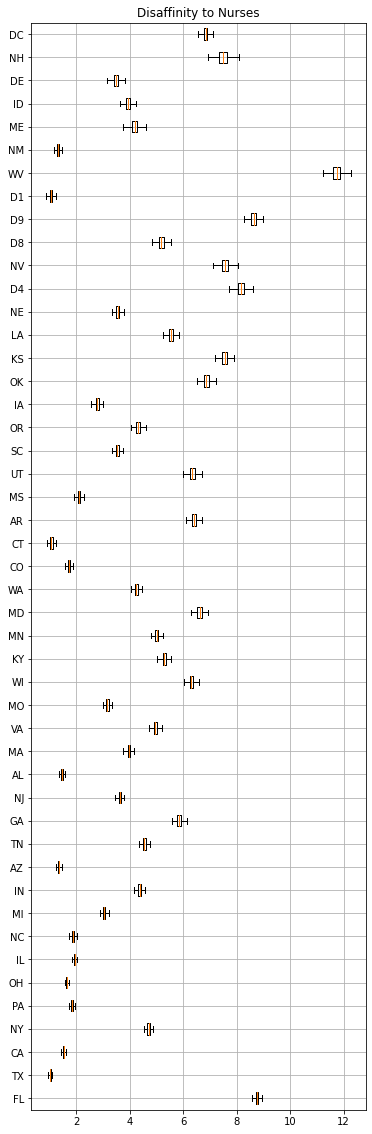

 
(D1: VT, RI     D2: ND,SD      D8: MT, WY     D9: HI, AK)


In [10]:
with open("state_desirability_2009onwards.dill", "rb") as f:
    p_list = dill.load(f)
    
forest_list = []
for p in p_list:
    for st in graduated_state_axis:
        try:
            forest_list.append(p[st])
        except:
            continue

            
fig1, ax1 = plt.subplots(figsize=(6,20))
ax1.boxplot(forest_list,vert=False,labels=graduated_state_axis,showfliers=False)
plt.grid()
ax1.set_title('Disaffinity to Nurses')
plt.show()

region_explain()

[back to top](#top_summary)

### Job scrapping

What factors account for the variation in disaffinity between states? We can hypothesize that perhaps the salary offered to nurses would be a great indicator. Let's scrap some salary data and see what salary distribution of states look like. The salary data was scrapped on 2/28/2001.

In [ ]:
max_entries = 2000

#mix the order to hopefully get past the captcha
itervals =[]
for st in state_census.index:
    for start in range(0, max_entries, 50):     
        itervals.append([st,start])
random.shuffle(itervals)

#also randomly choose the sleep interval by choosing lambda from normal distribution and using gillespie algorithm+1
sleep_mean = np.random.gamma(2, scale = 0.25, size=len(itervals))
sleep_rand = np.random.rand(len(itervals))
sleep_val = sleep_mean * np.log(1/sleep_rand)+0.5

#sleep_val = np.random.normal(loc=1.5, scale = 0.25, size=len(itervals))
# sns.displot(sleep_val)

salary = dict.fromkeys(state_census.index)
headers = {'User-Agent': 'Mozilla/5.0 (Linux; Android 9; SM-G960F Build/PPR1.180610.011; wv) AppleWebKit/537.36 (KHTML, like Gecko)Version/4.0 Chrome/74.0.3729.157 Mobile Safari/537.36'}

#vpn setup
instructions = initialize_VPN(area_input=['united states'])
rotate_VPN(instructions)

for i, val in tqdm(enumerate(itervals)):

    start = val[1]
    st = val[0]
    
    stn = state_census.loc[st,'STNAME']
    if len(st.split())>1:
        state = '+'.join(stn.split())
    else:
        state = stn
    url = "https://www.indeed.com/jobs?q=Registered+Nurse&l="+state+"&radius=0&jt=fulltime&limit=50&sort=date&taxo2=l1Pv1F0MQ3-LPU6ePM7Rdg&start="+str(start)
    html = requests.get(url,headers=headers)
    soup = BeautifulSoup(html.text, 'html.parser')
    
    while 'Captcha' in soup.title.text:
        #webbrowser.open('url', new=0)
        rotate_VPN(instructions)
        html = requests.get(url)
        soup = BeautifulSoup(html.text, 'html.parser')
    
    #for result in soup.find_all('span', {'class':'salaryText'}):
    for result in soup.find_all('span', {'class':'salary-snippet'}):
        if salary[st] is None:
            salary[st]=[result.text]
        else:
            salary[st].append(result.text)   
        
        # print(result.text)  
    if sleep_val[i]>0:
        sleep(sleep_val[i])
    else:
        sleep(2)
        
with open("salary_scrap.pkl","wb") as f:
    pickle.dump(salary,f)

In [11]:
with open("salary_scrap.pkl","rb") as f:
    salary = pickle.load(f)

nlp = spacy.load("en_core_web_md")
timenames = ['week','wk','year','yr','day','hour','hr','month']

paydata=dict.fromkeys(state_census.index)

for st in state_census.index:
    results = salary[st]
    
    for result in results:      
        found = 0 #find if one of the time names are in the string I collected

        for tname in timenames:
            if tname in result:
                found = 1      
                break        
        if found:
            amount = []
            doc = nlp(result)
            for token in doc:
                if token.pos_ == 'NUM':
                    try:
                        amount.append(float(token.text.replace(",", "")))
                    except:
                        pass
            if amount:
                pay = np.mean(amount)
                if tname in ['week','wk']:
                    pay = pay*52
                elif tname in ['hour','hr']:
                    pay  = pay*40*52
                elif tname =='day':
                    pay = pay*5*52
                elif tname == 'month':
                    pay = pay*12
                
                if paydata[st]:
                    paydata[st].append(pay)
                else:
                    paydata[st]=[pay]
                    

#remove outiers
paydata_clean=dict.fromkeys(state_census.index)

for st in state_census.index:
    mad = stats.median_abs_deviation(paydata[st],scale='normal')
    med_pay = np.median(paydata[st])
    paydata_clean[st] = [pay for pay in paydata[st] if abs(pay-med_pay)<3*mad]

print('Average Salary by State (dollars)')
print("------------------------------------------------")

report = ''
for i, st in enumerate(state_census.index):
    report+='{}: {:6.0f}     '.format(st,np.mean(paydata_clean[st]))
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)


Average Salary by State (dollars)
------------------------------------------------
AL:  70302     AK:  88769     AZ:  75013     AR:  66243     
CA: 108629     CO:  74529     CT:  90137     DE:  71114     
DC:  88141     FL:  82345     GA:  88211     HI: 102143     
ID:  82075     IL:  76150     IN:  68100     IA:  62136     
KS:  58905     KY:  67170     LA:  75168     ME:  76733     
MD:  87309     MA:  73120     MI:  71140     MN:  66172     
MS:  60270     MO:  74387     MT:  75331     NE:  64356     
NV: 102034     NH:  77259     NJ:  77092     NM:  76025     
NY:  85868     NC:  72259     ND:  85891     OH:  66154     
OK:  76451     OR:  82893     PA:  65737     RI:  79909     
SC:  79993     SD:  64016     TN:  68319     TX:  89729     
UT:  75076     VT:  74817     VA:  74154     WA:  93775     
WV:  61801     WI:  75351     WY:  60783     


Salary maybe not directly comparable due to two reasons.

1. Cost of living differs between states, which also affects the salary level (i.e. 130k job in San Fransico is not the same as 130k job in rural areas)
2. Progressive taxation rescales the salary (i.e. moving to a region with twice the cost of living, one must earn more than twice their original salary to maintain buying power)

To account for this, we can calculate the adjusted salary by dividing after-tax salary by the cost of living index. Doing so will give the buying power offered by a position. Then, we can do a linear regression on the raw salary and the adjusted salary versus the disaffinity values we calculated.

2 different dataset will be used to do the regression. One is the median set, where we are taking one data point per state, taking the median from the distribution. The other is the bootstrapped dataset, where I sample randomly from the salaray data, as well as the disaffinity distribution.

Sources:

    Cost of living: https://meric.mo.gov/data/cost-living-data-series
    Tax bracket: https://www.irs.gov/newsroom/irs-provides-tax-inflation-adjustments-for-tax-year-2021

In [14]:
url = "https://meric.mo.gov/data/cost-living-data-series"
html = requests.get(url)
soup = BeautifulSoup(html.text, 'html.parser')
    
tablelist=[]
columns = []
#for result in soup.find_all('span', {'class':'salaryText'}):
table = soup.find_all('table', {'class':'table'})[1]
for row in table.findAll("tr"):
    rowlist=  []
    for cell in row.findAll("td"):
        try:
            rowlist.append(float(cell.text.strip()))
        except:
            rowlist.append(cell.text.strip())  
    tablelist.append(rowlist)
    
for header in table.findAll("th"):
    columns.append(header.text.strip())  

vallist = np.delete(np.array([row[2:] for row in tablelist[1:53]]),28,0)
stlist =  np.delete(np.array([row[1] for row in tablelist[1:53]]),28,0)

for i in range(vallist.shape[0]):
    statename = stlist[i].strip()
    stlist[i] = stname.index[stname.STNAME==statename][0]
    
col_df = pd.DataFrame(vallist,index=stlist,columns = columns[2:])
    
"""
Tax model and cost of living to normalize wages
compare this to how much people hate that state
"""


from tax_bracket import tax_bracket

print('Median Adjusted Income')
print('post-tax salary / cost of living Index')
print("------------------------------------------------")

report = ''
for i, st in enumerate(state_census.index):
    report+='{}: {:.0f}    '.format(st,100*np.median(tax_bracket(paydata_clean[st]))/col_df.loc[st,'Index'])
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)


Median Adjusted Income
post-tax salary / cost of living Index
------------------------------------------------
AL: 64473    AK: 56978    AZ: 61777    AR: 58602    
CA: 57421    CO: 61225    CT: 58373    DE: 54716    
DC: 47580    FL: 64119    GA: 75644    HI: 45328    
ID: 70533    IL: 68862    IN: 62913    IA: 58325    
KS: 59013    KY: 63305    LA: 66108    ME: 52815    
MD: 54619    MA: 46572    MI: 68311    MN: 58117    
MS: 60139    MO: 67732    MT: 57653    NE: 59331    
NV: 69358    NH: 55714    NJ: 57398    NM: 71441    
NY: 48311    NC: 62165    ND: 70725    OH: 60395    
OK: 70370    OR: 52570    PA: 54338    RI: 56055    
SC: 69062    SD: 55796    TN: 66600    TX: 74634    
UT: 62142    VT: 53609    VA: 60856    WA: 67831    
WV: 53135    WI: 66264    WY: 50334    


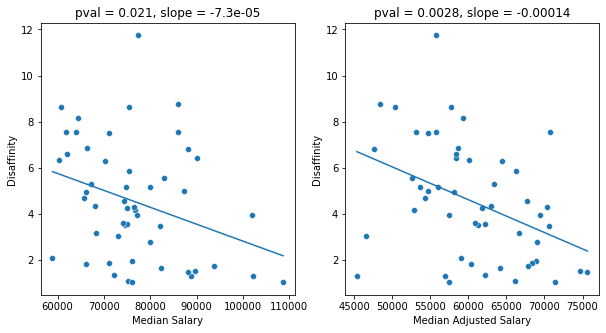

In [16]:
state_to_plist = []
for st in state_census.index:
    p_st = st

    if st in graduated_state_axis:
        for i in range(len(p_list)):
            if st == p_list[i].varnames[1]:
                state_to_plist.append((i, p_st))
                break
    else:
        for key in region:
            if st in region[key]:
                for i in range(len(p_list)):
                    if key == p_list[i].varnames[1]:
                        state_to_plist.append((i, key))
                        break



df_salary = pd.DataFrame({'salary': [np.mean(paydata_clean[st]) for st in state_census.index],
                         'CoL': [col_df.loc[st, 'Index'] for st in state_census.index],
                         # income index
                         'adjusted': [100*np.median(tax_bracket(paydata_clean[st]))/col_df.loc[st, 'Index'] for st in state_census.index],
                         'DA': [np.median(p_list[i][p_st]) for i, p_st in state_to_plist]},  # disaffinity
                        index=state_census.index)

xvars = ['salary', 'adjusted']
xlabels = ['Median Salary', 'Median Adjusted Salary']

z = [stats.linregress(df_salary.salary, df_salary.DA),
                      stats.linregress(df_salary.adjusted, df_salary.DA)]
xp = [np.linspace(min(df_salary.salary), max(df_salary.salary), 10000), np.linspace(
    min(df_salary.adjusted), max(df_salary.adjusted), 10000)]
yp = [z[i].slope*xp[i]+z[i].intercept for i in range(2)]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    sns.scatterplot(data=df_salary, x=xvars[i], y='DA', ax=ax[i])
    sns.lineplot(x=xp[i], y=yp[i], ax=ax[i])
    ax[i].set_title('pval = {:.2}, slope = {:.2}'.format(
        z[i].pvalue, z[i].slope))
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Disaffinity')
plt.show()

47it [00:07,  6.65it/s]


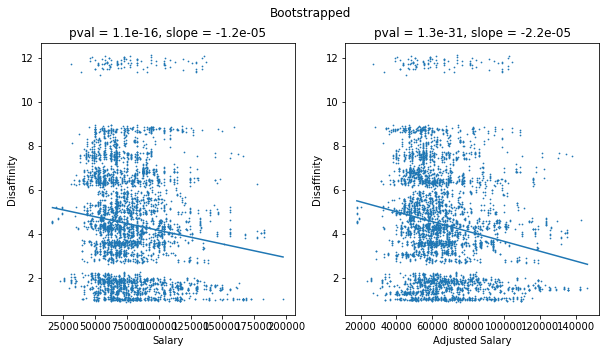

In [18]:
""" bootstrapping """
n_sample = 100
# [p drawn from p_list,salary drawn from adjusted]
boot = np.zeros(shape=[len(graduated_state_axis)*n_sample, 3])

counter = 0
for i, st in tqdm(enumerate(graduated_state_axis)):
    if st in region:
        salary = []
        for s in region[st]:
            salary.extend(paydata_clean[s])
    else:
        salary = paydata_clean[st]
    # remove outliers from p
    for p_set in p_list:
        if st == p_set.varnames[1]:
            DA_vals = p_set[st]
            break
    mad = stats.median_abs_deviation(DA_vals, scale='normal')
    med_p = np.median(DA_vals)
    clean_p = [val for val in DA_vals if abs(val-med_p) < 3*mad]
    # clean_p = p_list[i].p
    for ii in range(n_sample):
        boot[counter, 0] = np.random.choice(clean_p)
        boot[counter, 1] = np.random.choice(salary)
        boot[counter, 2] = 100*tax_bracket([boot[counter, 1]])/np.mean(
            [col_df.loc[s, 'Index'] for s in r2slist(st)])
        counter += 1


z = [stats.linregress(boot[:, 1], boot[:, 0]),
                      stats.linregress(boot[:, 2], boot[:, 0])]
xp = [np.linspace(min(boot[:, 1]), max(boot[:, 1]), 10000),
                  np.linspace(min(boot[:, 2]), max(boot[:, 2]), 10000)]
yp = [z[i].slope*xp[i]+z[i].intercept for i in range(2)]

xlim = [(50000, 120000), (400, 800)]
xlabels = ['Salary', 'Adjusted Salary']
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    ax[i].scatter(boot[:, i+1], boot[:, 0], s=0.5)
    sns.lineplot(x=xp[i], y=yp[i], ax=ax[i])
    ax[i].set_title('pval = {:.2}, slope = {:.2}'.format(
        z[i].pvalue, z[i].slope))
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Disaffinity')
    # ax[i].set_xlim(xlim[i])
fig.suptitle('Bootstrapped')
plt.show()

So, there definitely is an inverse relation between both salaries and disaffinity, but the raw salary is a much better predictor (smaller p value).

We can now collect other state-level measures that may predict the disaffinity, and build a predictive model. Analyzing the model will allow us to pinpoint metrics that can reduce disaffinity, and thereby make it more likely to retain nurses in a state

In [22]:
import os
""" institutional data"""
response = requests.get(
    "https://datausa.io/api/data?CIP=513801&measures=State%20Tuition,Out%20Of%20State%20Tuition,Completions&drilldowns=State,University,Sector")
df_institutions = pd.json_normalize(json.loads(response.text)['data'])
#get state for df_institutions
for state in df_institutions['State'].unique():
    try:
        st = state_census.index[state_census['STNAME']==state][0]
        df_institutions['State'][df_institutions['State']==state]=st
    except:
        continue

response = requests.get(
    "https://datausa.io/api/data?CIP=513801&measures=State%20Tuition,Total%20Graduates,Out%20Of%20State%20Tuition&drilldowns=University&order=Total Graduates&sort=desc")
df_tuition = pd.json_normalize(json.loads(response.text)['data'])


#get state for df_tuition
df_tuition['State']=''
not_found=[]
search_string = ''
for uid in df_tuition['ID University'].unique():
    try:
        st = df_institutions.loc[lambda df:(df['ID University'] == uid), 'State'].to_numpy()[0]
        df_tuition['State'][df_tuition['ID University']==uid] = st
    except:
        # continue
        univ = df_tuition['University'][df_tuition['ID University']==uid].values[0]
        grad = df_tuition['Total Graduates'][df_tuition['ID University']==uid].sum()
        # print('{} ({}, {}) doenst exist'.format(univ, grad, uid))
        search_string=search_string+','+uid
        not_found.append(uid)
search_string = search_string[1:]
df_st_yr_search = pd.read_csv('st_yr_search.csv',header=None)

for i,row in df_st_yr_search.iterrows():
    uid =str(row[0])
    st = row[3]
    
    if st in state_census.index:
        df_tuition['State'][df_tuition['ID University']==uid] = st
    else:
        df_tuition.drop(labels=df_tuition.index[df_tuition['ID University']==uid],inplace=True)

df_tuition.drop(labels=df_tuition.index[df_tuition['State']==''],inplace=True)



"""employment stats"""
#download and rename
for yr in tqdm(range(2009,2016)):    
    zipurl='https://www.bls.gov/oes/special.requests/oesm'+str(yr)[2:]+'st.zip'
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('tmp')
try:
    os.rename(r'tmp\\state_dl.xls',r'tmp\\state_M2009_dl.xls')
except:
    pass

files = []
for f in os.walk('tmp'):
    for fname in f[2]:
        if any([str(yr) in fname for yr in range(2008,2016)]):
            files.append(os.path.join(f[0],fname))
 
#parse
emp_list={}
for yr in tqdm(range(2009,2016)):
    fpath = files[[str(yr) in fn for fn in files].index(True)]
    try:
        df_test = pd.read_excel(fpath)
    except:
        df_test = pd.read_excel(fpath,engine='openpyxl')    
    
    
    if (df_test['OCC_CODE']=='29-1111').sum()>0:
        df_emp = df_test.loc[lambda df: (df['OCC_CODE'] == '29-1111'), :]
    else:
        df_emp = df_test.loc[lambda df: (df['OCC_CODE'] == '29-1141'), :]
    df_emp.set_index('ST', inplace=True)
    emp_list[str(yr)] = df_emp



"""helper functions"""
def total_grad(st, yr):
    if st in region:
        states = region[st]
    else:
        states = [st]
        
    vals=[]
    for state in states:
        vals.append(df_institutions.loc[lambda df:(df.State == state) & (df.Year == str(yr)), 'Completions'].sum())
    return np.sum(vals)


def total_pop(st, yr):
    return movement[str(yr)].loc[st, :].sum()

def mean_tuition(st,yr,status='in'):   
    if st in region:
        states = region[st]
    else:
        states = [st]
    tot_tuition=[]
    tot_grad=[]
    for state in states:     
        df_state = df_tuition.loc[(df_tuition['State']==state)&(df_tuition['Year']==str(yr)),:]
        if status =='in':
            tot_tuition.append((df_state['State Tuition']*df_state['Total Graduates']).sum())
            tot_grad.append(df_state['Total Graduates'].sum())
        elif status =='out':
            tot_tuition.append((df_state['Out Of State Tuition']*df_state['Total Graduates']).sum())
            tot_grad.append(df_state['Total Graduates'].sum())
    return np.sum(tot_tuition)/np.sum(tot_grad)

def total_nurses(st,yr):
    df_emp = emp_list[str(yr)]
    
    if st in region:
        states = region[st]
    else:
        states = [st]      
    vals=[]
    

    for state in states:
        #float(df_emp.loc[st,'TOT_EMP'].replace(',',''))
        vals.append(float(df_emp.loc[state,'TOT_EMP']))
    return np.sum(vals)

    
def median_wage(st,yr,scale='A'):
    df_emp = emp_list[str(yr)]
    
    if st in region:
        states = region[st]
    else:
        states = [st]
    
    wage=[]
    tot_nurse=[]
    for state in states:
        #float(df_emp.loc[st,scale+'_MEDIAN'].replace(',',''))
        wage.append(float(df_emp.loc[state,scale+'_MEDIAN']))
        tot_nurse.append(float(df_emp.loc[state,'TOT_EMP']))
                
    return np.sum(np.multiply(wage,tot_nurse))/np.sum(tot_nurse)


<ipython-input-22-995df3fb12bd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_institutions['State'][df_institutions['State']==state]=st
<ipython-input-22-995df3fb12bd>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tuition['State'][df_tuition['ID University']==uid] = st
<ipython-input-22-995df3fb12bd>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tuition['State'][df_tuition['ID University']==uid] = st
100%|█████████

In [25]:
with open("state_desirability_2009onwards.dill", "rb") as f:
    p_list = dill.load(f)
    
def get_factors(st,yrs=range(2013, 2016)):
    f=[]       
    f.append(np.mean([median_wage(st,yr) for yr in yrs]))
    f.append(np.mean([total_grad(st,yr)/total_nurses(st,yr) for yr in yrs]))
    f.append(np.mean([mean_tuition(st,yr,status='in')/median_wage(st,yr) for yr in yrs]))
    return np.array(f)
 
factors = np.zeros((47,3))
for i, st in enumerate(graduated_state_axis):  
    factors[i,:] = get_factors(st,range(2013,2016))
    
df_factors = pd.DataFrame(data=factors,index=graduated_state_axis,columns=['s','g_n','it'])
df_DA =pd.DataFrame(data=[np.median(p_list[i][st]) for i, st in enumerate(graduated_state_axis)],index=graduated_state_axis)

X = df_factors
y = df_DA
model=linear_model.LinearRegression().fit(X.to_numpy(),y.to_numpy())

cor =df_factors.corr()
for i in range(cor.shape[0]):
    for j in range(cor.shape[0]):
        if (i>j)&(abs(cor.iloc[i,j])>0.9):
            print('{} and {} ({})'.format(df_library.columns[i],df_library.columns[j], cor.iloc[i,j]))

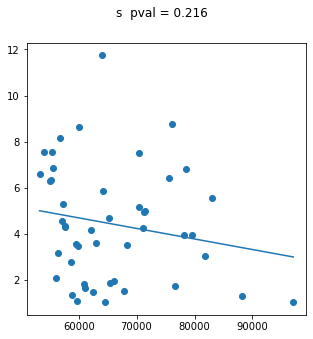

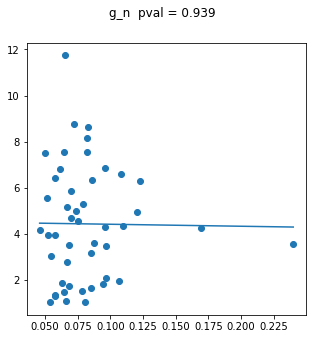

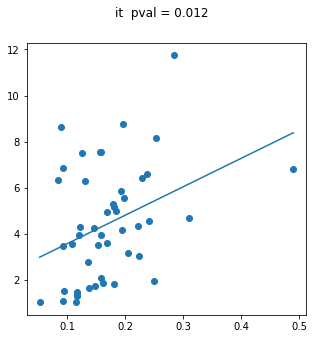

In [28]:
for i in range(3):
    name = df_factors.columns[i]
    x = df_factors.iloc[:,i].to_numpy()
    y = df_DA.iloc[:,0].to_numpy()
    
    z = stats.linregress(x,y)
    
    xp=np.linspace(min(x), max(x), 10)
    yp=z.slope*xp+z.intercept

    plt.figure(figsize=(5,5))

    plt.scatter(x,y)
    plt.plot(xp,yp)
    plt.suptitle('{}  pval = {:.3f}'.format(name,z.pvalue))
    plt.show()

We will only consider the salaray and tuiton/salary, since graduates/nurse is a bad predictor(large p value). Using this model and the disaffinity, we can calculate what it would take to increase the number of new nurses in a state by a target amount. To increase new nurses by 1% from purely increasing the number of instate graduates who stay:

In [30]:
target=0.01

print('To get {:}% increase in new nurses'.format(target*100))
print('')
print('')
print('{:^8}{:^25}{:^25}{:^25}'.format('state','Salary Increase($)','Enrollment Increase(%)','Tuition Decrease($)'))
for si, state in enumerate(graduated_state_axis):

    DA = df_DA.loc[state,0]
    # probability that people will move from 'state' to other state
    leave_list=[]
    for year in range(2013, 2016):
        yr = str(year)
        total = movement[yr].loc[:, state].sum()
        stay = movement[yr].loc[state, state]
        leave_list.append(1-(stay/total))
    gen_pop_leave = np.mean(leave_list)
    nurse_leave = DA*gen_pop_leave   
    instate = hm_fg[si,si]/hm_fg[:,si].sum()
    
    percent_DA_change_target = target*(1-nurse_leave)/(nurse_leave*instate)
    
    DA_change_target = DA*percent_DA_change_target
    pars = [1/model.coef_[0][i] for i in range(3)]
    
    t = np.mean([mean_tuition(st,y,status='in') for y in range(2013, 2016)])
    s = np.mean([median_wage(st,y) for y in range(2013, 2016)])
    pars[0] = 1/(model.coef_[0][0]-model.coef_[0][2]*t/(s**2))
    pars[2] = s/model.coef_[0][2]
    
    print('{:^8}{:^25.0f}{:^25.0f}{:^25.0f}'.format(state,-pars[0]*DA_change_target,-pars[1]*DA_change_target*100,pars[2]*DA_change_target))

To get 1.0% increase in new nurses


 state     Salary Increase($)     Enrollment Increase(%)     Tuition Decrease($)   
   FL             3278                      16                      2794           
   TX             4208                      21                      3587           
   CA             4555                      23                      3882           
   NY             3072                      15                      2619           
   PA             3303                      17                      2815           
   OH             3872                      19                      3301           
   IL             2774                      14                      2365           
   NC             2860                      14                      2438           
   MI             3958                      20                      3374           
   IN             3065                      15                      2613           
   AZ             2219                 

<a id='cost'></a>
We can calculate the cost of the entire program from these numbers. For example, let's say we offer a linearly decaying salary bonus for 5 years to nurses who stay after graduation. What is this program's cost compared to reducing the tuition? We will assume that nursing programs last 4 years, and the reduced tuition will be in effect for all 4 years.

[back to top](#top_summary)

In [31]:
"""estimate cost"""
yr_length = 5
print('Program cost($ million): decaying salaray bonus over {} years vs. tuition decrease'.format(yr_length))
print('{:^8}{:^20}{:^20}'.format('state','Salary Bonus','Tuition Decrease'))
for si, state in enumerate(graduated_state_axis):

    DA = df_DA.loc[state,0]
    # probability that people will move from 'state' to other state
    leave_list=[]
    for year in range(2013, 2016):
        yr = str(year)
        total = movement[yr].loc[:, state].sum()
        stay = movement[yr].loc[state, state]
        leave_list.append(1-(stay/total))
    gen_pop_leave = np.mean(leave_list)
    nurse_leave = DA*gen_pop_leave   #% of graduates who leave
    instate = hm_fg[si,si]/hm_fg[:,si].sum()  #% of new nurses who are from instate
    
    percent_DA_change_target = target*(1-nurse_leave)/(nurse_leave*instate)
    
    if state in region:
        students_per_year=0
        for s in region[state]:
            students_per_year += df_institutions.loc[lambda df:(df['State']==s)&(df['Year']=='2019'),'Completions'].sum()
    else:
        students_per_year = df_institutions.loc[lambda df:(df['State']==state)&(df['Year']=='2019'),'Completions'].sum()
        
    new_instate_nurse = students_per_year*(1-nurse_leave)
    
    DA_change_target = DA*percent_DA_change_target
    pars = [1/model.coef_[0][i] for i in range(3)]
    
    t = np.mean([mean_tuition(st,y,status='in') for y in range(2013, 2016)])
    s = np.mean([median_wage(st,y) for y in range(2013, 2016)])
    pars[0] = 1/(model.coef_[0][0]-model.coef_[0][2]*t/(s**2))
    pars[2] = s/model.coef_[0][2]
    
    cost_s = -pars[0]*DA_change_target*yr_length/2*new_instate_nurse
    cost_t = pars[2]*DA_change_target*4*students_per_year
    print('{:^8}{:^20.1f}{:^20.1f}'.format(state,cost_s/1000000,cost_t/1000000))


Program cost($ million): decaying salaray bonus over 5 years vs. tuition decrease
 state      Salary Bonus      Tuition Decrease  
   FL          132.3               187.3        
   TX          185.4               259.3        
   CA          172.8               239.5        
   NY           80.7               135.7        
   PA           74.3               111.9        
   OH          113.3               159.9        
   IL          108.3               155.3        
   NC           43.0                60.7        
   MI           60.5                85.4        
   IN           37.9                57.0        
   AZ           45.2                70.3        
   TN           30.8                45.8        
   GA           35.0                49.6        
   NJ           32.3                48.6        
   AL           40.2                63.4        
   MA           32.7                48.2        
   VA           27.1                41.6        
   MO           26.3                